# PHASE 1: FORENSIC DATA EXPLORATION & CLEANING

In [ ]:
# Model 1 (Operational) - Southern England Freight Network
# =============================================================================
#
# Notebook: 02_eda.ipynb
#
# This phase covers:
#   1.1.1 Data Quality Assessment
#   1.1.2 Univariate Analysis
#   1.1.3 Missing Data Strategy
#   1.1.4 Target Variable Establishment
#
# =============================================================================



# # Phase 1: Forensic Data Exploration & Cleaning
# ## Model1 to create (Operational) - Southern England Freight Network
# 
# **Objective**: Understand data quality, distributions, and establish modeling targets
# 
# **Dataset**: 137,556 hourly HGV traffic observations from Southern England
# 
# ---

 ## Cell 1: Imports and Load Data

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import pearsonr, spearmanr, kruskal, mannwhitneyu
from scipy.stats import poisson, nbinom
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10
plt.rcParams['axes.titlesize'] = 12
plt.rcParams['axes.labelsize'] = 10

# Paths
PROCESSED_DIR = "../data/processed"
OUTPUT_DIR = "../outputs/phase1"

# Create output directory for plots
import os
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Load the dataset
print(" LOADING MODEL 1 DATASET")
print("=" * 60)

df = pd.read_parquet(os.path.join(PROCESSED_DIR, "model1_operational_dataset.parquet"))

print(f"✓ Dataset loaded successfully")
print(f"  Shape: {df.shape[0]:,} rows × {df.shape[1]} columns")
print(f"  Memory: {df.memory_usage(deep=True).sum() / 1e6:.1f} MB")

# Quick column overview
print(f"\n COLUMNS ({len(df.columns)}):")
for i, col in enumerate(df.columns):
    dtype = df[col].dtype
    print(f"  {i+1:2}. {col} ({dtype})")

 LOADING MODEL 1 DATASET
✓ Dataset loaded successfully
  Shape: 137,556 rows × 24 columns
  Memory: 30.6 MB

 COLUMNS (24):
   1. count_point_id (int32)
   2. direction_of_travel (category)
   3. grid_id (int64)
   4. year (int16)
   5. count_date (datetime64[ns])
   6. hour (int8)
   7. region_id (int8)
   8. local_authority_id (Int16)
   9. road_name (object)
  10. road_category (object)
  11. road_type (object)
  12. latitude (float32)
  13. longitude (float32)
  14. lgvs (int16)
  15. all_motor_vehicles (int32)
  16. all_hgvs (int16)
  17. temp_c (float32)
  18. rain_mm (float32)
  19. snow_cm (float32)
  20. wind_kph (float32)
  21. weather_code (int16)
  22. visibility_category (int8)
  23. is_fog (int8)
  24. is_reduced_visibility (int8)


## Cell 2: Data Quality Quick Check

In [3]:
print(" DATA QUALITY QUICK CHECK")
print("=" * 60)

# 1. Missing Values Check
print("\n1️ MISSING VALUES:")
missing = df.isnull().sum()
missing_pct = (missing / len(df) * 100).round(2)
missing_df = pd.DataFrame({'Missing': missing, 'Percent': missing_pct})
missing_df = missing_df[missing_df['Missing'] > 0]

if len(missing_df) == 0:
    print("  ✓ No missing values in any column")
else:
    print("   Missing values found:")
    print(missing_df.to_string())

# 2. Duplicate Check
print("\n DUPLICATE RECORDS:")
# Full duplicates
full_dupes = df.duplicated().sum()
print(f"  Full row duplicates: {full_dupes:,}")

# Key duplicates (same sensor, date, hour, direction)
key_cols = ['count_point_id', 'count_date', 'hour', 'direction_of_travel']
key_dupes = df.duplicated(subset=key_cols).sum()
print(f"  Key duplicates (sensor+date+hour+direction): {key_dupes:,}")

if full_dupes == 0 and key_dupes == 0:
    print(" ✓ No duplicate records found")
else:
    print("Duplicates detected - investigate before proceeding")

# 3. Data Type Validation
print("\n3️ DATA TYPE VALIDATION:")
expected_types = {
    'count_point_id': 'int',
    'year': 'int',
    'hour': 'int',
    'all_hgvs': 'int',
    'temp_c': 'float',
    'rain_mm': 'float',
    'latitude': 'float',
    'longitude': 'float'
}

type_issues = []
for col, expected in expected_types.items():
    if col in df.columns:
        actual = str(df[col].dtype)
        if expected not in actual:
            type_issues.append(f"{col}: expected {expected}, got {actual}")

if not type_issues:
    print(" ✓ All data types as expected")
else:
    print("Type issues:")
    for issue in type_issues:
        print(f"    • {issue}")

# Summary
print("\n" + "=" * 60)
print(" QUALITY CHECK SUMMARY")
print("=" * 60)
if len(missing_df) == 0 and full_dupes == 0 and key_dupes == 0:
    print(" Data quality checks PASSED - ready for analysis")
else:
    print("Issues found - review before proceeding")




 DATA QUALITY QUICK CHECK

1️ MISSING VALUES:
  ✓ No missing values in any column

 DUPLICATE RECORDS:
  Full row duplicates: 0
  Key duplicates (sensor+date+hour+direction): 0
 ✓ No duplicate records found

3️ DATA TYPE VALIDATION:
 ✓ All data types as expected

 QUALITY CHECK SUMMARY
 Data quality checks PASSED - ready for analysis


## Cell 3: Sensor Coverage & Temporal Gap Assessment

 SENSOR COVERAGE & TEMPORAL GAP ASSESSMENT

1️ OVERALL TEMPORAL COVERAGE:
  Date range: 2022-03-18 to 2024-11-07
  Total span: 966 days (31.7 months)
  Unique dates with data: 334 (34.6% of span)

 OBSERVATIONS PER SENSOR:
  Total sensors: 4,611
  Observations per sensor:
    Min: 12
    25th percentile: 24
    Median: 24
    75th percentile: 24
    Max: 72
    Mean: 29.8

  Sparse sensors (<20 obs): 149 (3.2%)

 HOUR COVERAGE:
  Hours present: [np.int8(7), np.int8(8), np.int8(9), np.int8(10), np.int8(11), np.int8(12), np.int8(13), np.int8(14), np.int8(15), np.int8(16), np.int8(17), np.int8(18)]
  Hour range: 7 to 18
   Missing hours: [0, 1, 2, 3, 4, 5, 6, 19, 20, 21, 22, 23]
     Note: DfT data often covers 7am-7pm only (daylight hours)

 YEAR-MONTH DISTRIBUTION:
  Months with data: 24
  Observations per month:
    Min: 120 (2022-11)
    Max: 10,464 (2024-04)
    Mean: 5,732
   Missing months: [Period('2022-08', 'M'), Period('2022-12', 'M'), Period('2023-01', 'M'), Period('2023-02', '

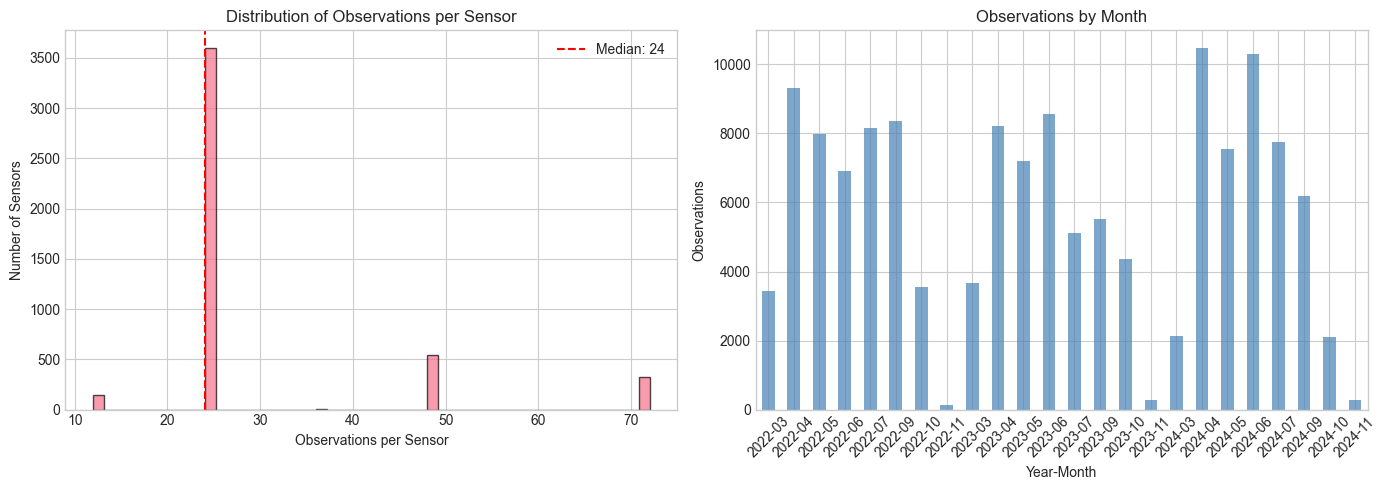


✓ Plot saved to ../outputs/phase1/sensor_temporal_coverage.png


In [4]:
print(" SENSOR COVERAGE & TEMPORAL GAP ASSESSMENT")
print("=" * 60)

# 1. Overall temporal coverage
print("\n1️ OVERALL TEMPORAL COVERAGE:")
date_min = df['count_date'].min()
date_max = df['count_date'].max()
total_days = (date_max - date_min).days + 1

print(f"  Date range: {date_min.date()} to {date_max.date()}")
print(f"  Total span: {total_days} days ({total_days/30.44:.1f} months)")

# Unique dates in data
unique_dates = df['count_date'].dt.date.nunique()
date_coverage = unique_dates / total_days * 100
print(f"  Unique dates with data: {unique_dates} ({date_coverage:.1f}% of span)")

# 2. Observations per sensor
print("\n OBSERVATIONS PER SENSOR:")
sensor_obs = df.groupby('count_point_id').size()

print(f"  Total sensors: {len(sensor_obs):,}")
print(f"  Observations per sensor:")
print(f"    Min: {sensor_obs.min()}")
print(f"    25th percentile: {sensor_obs.quantile(0.25):.0f}")
print(f"    Median: {sensor_obs.median():.0f}")
print(f"    75th percentile: {sensor_obs.quantile(0.75):.0f}")
print(f"    Max: {sensor_obs.max()}")
print(f"    Mean: {sensor_obs.mean():.1f}")

# Sensors with very few observations
sparse_sensors = (sensor_obs < 20).sum()
sparse_pct = sparse_sensors / len(sensor_obs) * 100
print(f"\n  Sparse sensors (<20 obs): {sparse_sensors} ({sparse_pct:.1f}%)")

# 3. Hour coverage analysis
print("\n HOUR COVERAGE:")
hour_counts = df['hour'].value_counts().sort_index()
print(f"  Hours present: {sorted(df['hour'].unique())}")
print(f"  Hour range: {df['hour'].min()} to {df['hour'].max()}")

# Check if we have 24-hour coverage
if len(hour_counts) == 24:
    print("  ✓ Full 24-hour coverage")
else:
    missing_hours = set(range(24)) - set(df['hour'].unique())
    print(f"   Missing hours: {sorted(missing_hours)}")
    print(f"     Note: DfT data often covers 7am-7pm only (daylight hours)")

# 4. Year-Month distribution
print("\n YEAR-MONTH DISTRIBUTION:")
df['year_month'] = df['count_date'].dt.to_period('M')
ym_counts = df.groupby('year_month').size()

print(f"  Months with data: {len(ym_counts)}")
print(f"  Observations per month:")
print(f"    Min: {ym_counts.min():,} ({ym_counts.idxmin()})")
print(f"    Max: {ym_counts.max():,} ({ym_counts.idxmax()})")
print(f"    Mean: {ym_counts.mean():,.0f}")

# Check for missing months
all_months = pd.period_range(start=date_min, end=date_max, freq='M')
missing_months = set(all_months) - set(ym_counts.index)
if missing_months:
    print(f"   Missing months: {sorted(missing_months)}")
else:
    print("  ✓ All months in range have data")

# 5. Day of week coverage
print("\n DAY OF WEEK COVERAGE:")
df['day_of_week'] = df['count_date'].dt.dayofweek
dow_names = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
dow_counts = df['day_of_week'].value_counts().sort_index()

for dow, count in dow_counts.items():
    pct = count / len(df) * 100
    print(f"  {dow_names[dow]}: {count:,} ({pct:.1f}%)")

# 6. Sensor-Date sparsity analysis
print("\n SENSOR TEMPORAL SPARSITY:")
sensor_date_counts = df.groupby('count_point_id')['count_date'].nunique()
max_possible_dates = unique_dates

avg_date_coverage = sensor_date_counts.mean() / max_possible_dates * 100
print(f"  Average dates per sensor: {sensor_date_counts.mean():.1f} / {max_possible_dates}")
print(f"  Average temporal coverage: {avg_date_coverage:.1f}%")

# This is expected - DfT rotates sensors
print(f"\n NOTE: Low per-sensor coverage is EXPECTED.")
print(f"     DfT uses rotating sensor deployment - sensors are not")
print(f"     continuously active. This is a known limitation.")

# Visualize sensor observation distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram of observations per sensor
axes[0].hist(sensor_obs, bins=50, edgecolor='black', alpha=0.7)
axes[0].axvline(sensor_obs.median(), color='red', linestyle='--', label=f'Median: {sensor_obs.median():.0f}')
axes[0].set_xlabel('Observations per Sensor')
axes[0].set_ylabel('Number of Sensors')
axes[0].set_title('Distribution of Observations per Sensor')
axes[0].legend()

# Observations by month
ym_counts.plot(kind='bar', ax=axes[1], color='steelblue', alpha=0.7)
axes[1].set_xlabel('Year-Month')
axes[1].set_ylabel('Observations')
axes[1].set_title('Observations by Month')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'sensor_temporal_coverage.png'), dpi=150, bbox_inches='tight')
plt.show()

print(f"\n✓ Plot saved to {OUTPUT_DIR}/sensor_temporal_coverage.png")



 ## Cell 4: Outlier Detection (Domain-Based)



In [5]:
print("OUTLIER DETECTION (DOMAIN-BASED)")
print("=" * 60)

# 1. Target Variable (all_hgvs) Outliers
print("\nTARGET VARIABLE (all_hgvs) OUTLIERS:")

# Physical constraint: Max ~500 HGVs/hour/lane is capacity
# But some sensors measure multiple lanes, so higher is possible
# Use 99th and 99.9th percentiles as reference

p99 = df['all_hgvs'].quantile(0.99)
p999 = df['all_hgvs'].quantile(0.999)
p995 = df['all_hgvs'].quantile(0.995)

print(f"  Percentiles:")
print(f"    99th:   {p99:.0f} HGVs/hour")
print(f"    99.5th: {p995:.0f} HGVs/hour")
print(f"    99.9th: {p999:.0f} HGVs/hour")
print(f"    Max:    {df['all_hgvs'].max():.0f} HGVs/hour")

# Domain threshold: >500 is unusual for single lane
extreme_500 = (df['all_hgvs'] > 500).sum()
extreme_pct = extreme_500 / len(df) * 100
print(f"\n  Observations >500 HGVs/hour: {extreme_500:,} ({extreme_pct:.2f}%)")

# These might be multi-lane sensors or truly congested periods
# Let's examine them
if extreme_500 > 0:
    extreme_df = df[df['all_hgvs'] > 500]
    print(f"\n  Roads with >500 HGVs/hour:")
    extreme_roads = extreme_df.groupby('road_name').size().sort_values(ascending=False).head(10)
    for road, count in extreme_roads.items():
        print(f"    {road}: {count:,} observations")

# 2. Zero HGV counts
print("\n ZERO HGV COUNTS:")
zero_hgvs = (df['all_hgvs'] == 0).sum()
zero_pct = zero_hgvs / len(df) * 100
print(f"  Zero counts: {zero_hgvs:,} ({zero_pct:.1f}%)")

# Check if zeros are concentrated in specific hours (night)
if zero_hgvs > 0:
    zero_by_hour = df[df['all_hgvs'] == 0].groupby('hour').size()
    print(f"  Zero counts by hour (top 5):")
    for hour, count in zero_by_hour.sort_values(ascending=False).head(5).items():
        print(f"    Hour {hour}: {count:,}")

# 3. Weather variable outliers
print("\n3 WEATHER VARIABLE OUTLIERS:")

weather_vars = {
    'temp_c': {'min': -15, 'max': 40, 'desc': 'Temperature'},
    'rain_mm': {'min': 0, 'max': 50, 'desc': 'Rainfall'},
    'snow_cm': {'min': 0, 'max': 30, 'desc': 'Snowfall'},
    'wind_kph': {'min': 0, 'max': 150, 'desc': 'Wind Speed'}
}

for col, bounds in weather_vars.items():
    if col in df.columns:
        below = (df[col] < bounds['min']).sum()
        above = (df[col] > bounds['max']).sum()
        actual_min = df[col].min()
        actual_max = df[col].max()
        
        status = "✓" if below == 0 and above == 0 else "⚠️"
        print(f"  {status} {bounds['desc']} ({col}):")
        print(f"      Range: {actual_min:.1f} to {actual_max:.1f}")
        print(f"      Outside [{bounds['min']}, {bounds['max']}]: {below + above} obs")

# 4. Negative values check (should be impossible)
print("\n4 NEGATIVE VALUE CHECK:")
numeric_cols = df.select_dtypes(include=[np.number]).columns
negative_issues = []

for col in numeric_cols:
    if col not in ['longitude']:  # longitude can be negative
        neg_count = (df[col] < 0).sum()
        if neg_count > 0:
            negative_issues.append(f"{col}: {neg_count:,} negative values")

if not negative_issues:
    print("  ✓ No unexpected negative values")
else:
    print(" Negative values found:")
    for issue in negative_issues:
        print(f"    • {issue}")

# 5. Summary and recommendation
print("\n" + "=" * 60)
print(" OUTLIER ASSESSMENT SUMMARY")
print("=" * 60)

# Decision on extreme HGV values
print(f"""
RECOMMENDATION FOR EXTREME HGV VALUES (>{p995:.0f}):
  • Count: {(df['all_hgvs'] > p995).sum():,} observations ({(df['all_hgvs'] > p995).sum()/len(df)*100:.2f}%)
  • Decision: RETAIN these values
  • Rationale: 
    - Multi-lane sensors can legitimately record high counts
    - High-volume corridors (M25, M1) have genuine peaks
    - Christmas/pre-holiday periods show legitimate surges
    - Tree-based models (XGBoost) are robust to outliers
  • Alternative: Cap at 99.9th percentile ({p999:.0f}) if needed later
""")




OUTLIER DETECTION (DOMAIN-BASED)

TARGET VARIABLE (all_hgvs) OUTLIERS:
  Percentiles:
    99th:   706 HGVs/hour
    99.5th: 800 HGVs/hour
    99.9th: 949 HGVs/hour
    Max:    1290 HGVs/hour

  Observations >500 HGVs/hour: 4,783 (3.48%)

  Roads with >500 HGVs/hour:
    M1: 1,002 observations
    M6: 968 observations
    M62: 709 observations
    A14: 290 observations
    M25: 230 observations
    A1(M): 201 observations
    M60: 189 observations
    A282: 177 observations
    M5: 173 observations
    M42: 155 observations

 ZERO HGV COUNTS:
  Zero counts: 2,715 (2.0%)
  Zero counts by hour (top 5):
    Hour 18: 917
    Hour 17: 627
    Hour 16: 279
    Hour 15: 159
    Hour 14: 114

3 WEATHER VARIABLE OUTLIERS:
  ✓ Temperature (temp_c):
      Range: -2.8 to 30.8
      Outside [-15, 40]: 0 obs
  ✓ Rainfall (rain_mm):
      Range: 0.0 to 13.4
      Outside [0, 50]: 0 obs
  ✓ Snowfall (snow_cm):
      Range: 0.0 to 1.3
      Outside [0, 30]: 0 obs
  ✓ Wind Speed (wind_kph):
      Range: 

## Cell 5: Target Variable Distribution Analysis

 TARGET VARIABLE DISTRIBUTION ANALYSIS

 DESCRIPTIVE STATISTICS:
  Count: 137,556.00
  Mean: 103.89
  Std: 151.05
  Min: 0.00
  Q1 (25%): 13.00
  Median: 38.00
  Q3 (75%): 126.00
  Max: 1,290.00
  Skewness: 2.40
  Kurtosis: 6.53
  Variance: 22,816.25
  Var/Mean Ratio: 219.61

 DISTRIBUTION TYPE ASSESSMENT:
  Variance/Mean Ratio: 219.61
  → OVERDISPERSED (Var >> Mean)
  → Negative Binomial distribution likely better than Poisson

 NORMALITY TESTS:
  Shapiro-Wilk test (n=5000):
    Statistic: 0.6840
    p-value: 1.53e-70
    → Not Normal (α=0.05)

 LOG TRANSFORMATION ASSESSMENT:
  Original skewness: 2.40
  Log(1+x) skewness: -0.16
  → Log transformation REDUCES skewness
  → Consider log(1+all_hgvs) for linear models


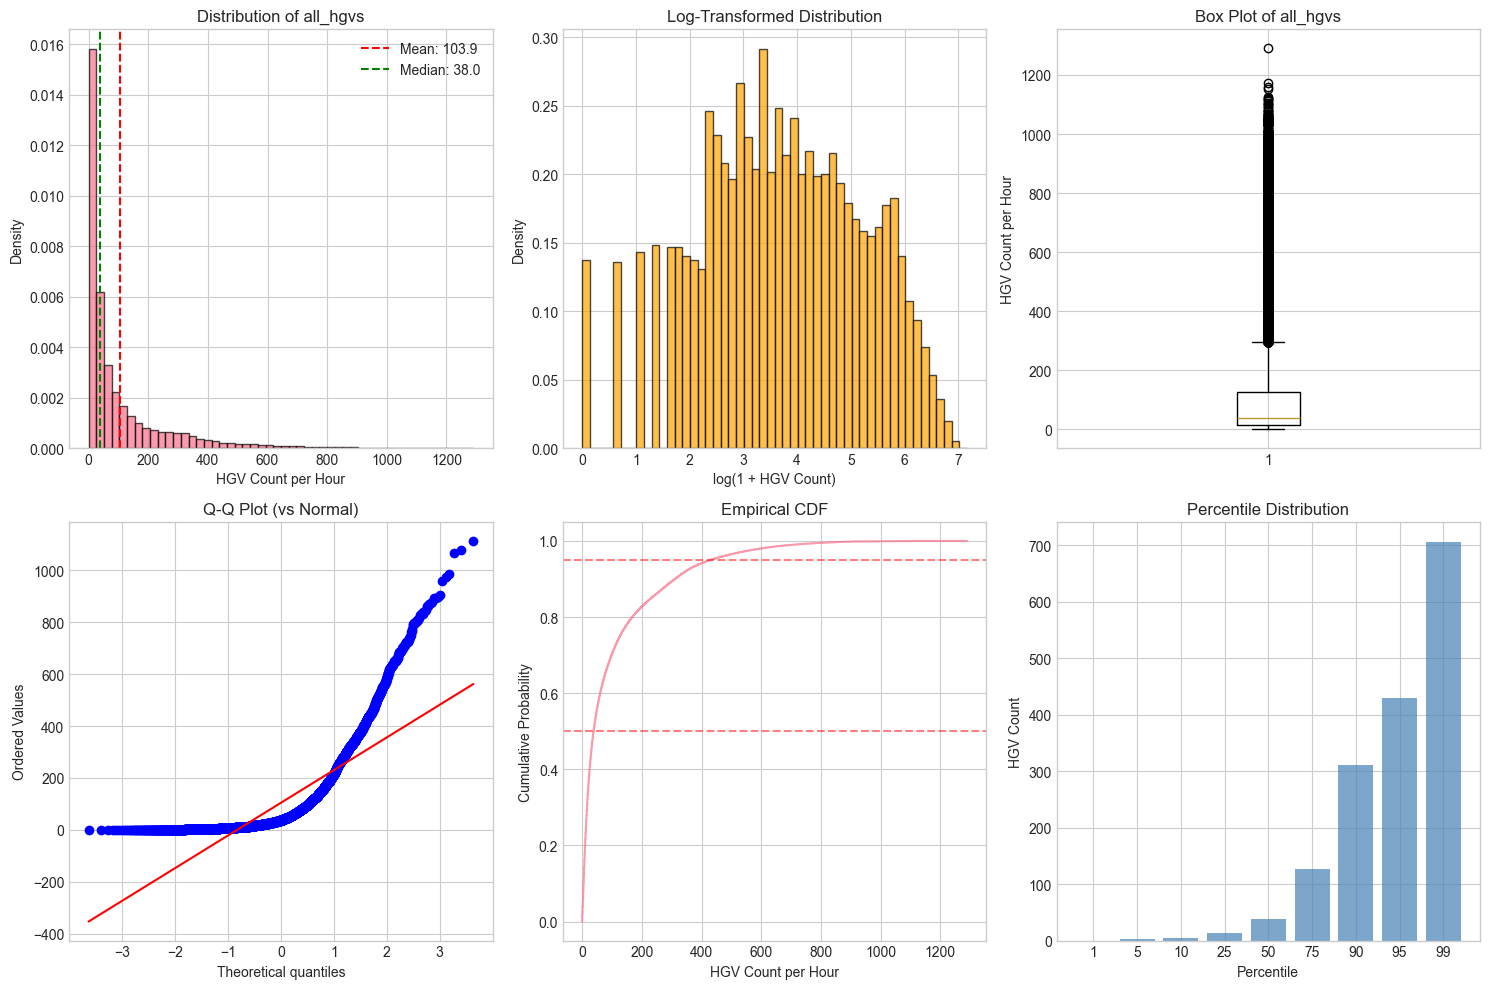


✓ Plot saved to ../outputs/phase1/target_distribution.png

 TARGET VARIABLE SUMMARY

TARGET: all_hgvs (Hourly HGV Count)
  • Distribution: Right-skewed, Negative Binomial recommended
  • Mean: 103.9, Median: 38.0
  • Range: 0 to 1290
  • Var/Mean Ratio: 219.61 (overdispersed)

MODELING IMPLICATIONS:
  • For tree-based models (XGBoost): Use raw counts - handles skewness well
  • For linear models: Consider log(1+x) transformation
  • For GLM: Use Negative Binomial regression (overdispersion)
  • Alternative target: Binary classification (High/Low HGV volume)



In [6]:
print(" TARGET VARIABLE DISTRIBUTION ANALYSIS")
print("=" * 60)

target = df['all_hgvs']

# 1. Basic Statistics
print("\n DESCRIPTIVE STATISTICS:")
stats_dict = {
    'Count': len(target),
    'Mean': target.mean(),
    'Std': target.std(),
    'Min': target.min(),
    'Q1 (25%)': target.quantile(0.25),
    'Median': target.median(),
    'Q3 (75%)': target.quantile(0.75),
    'Max': target.max(),
    'Skewness': target.skew(),
    'Kurtosis': target.kurtosis(),
    'Variance': target.var(),
    'Var/Mean Ratio': target.var() / target.mean()  # Dispersion index
}

for stat, value in stats_dict.items():
    print(f"  {stat}: {value:,.2f}")

# 2. Distribution Type Assessment
print("\n DISTRIBUTION TYPE ASSESSMENT:")

# Variance/Mean ratio indicates distribution type
var_mean_ratio = target.var() / target.mean()
print(f"  Variance/Mean Ratio: {var_mean_ratio:.2f}")

if var_mean_ratio > 1.5:
    print(f"  → OVERDISPERSED (Var >> Mean)")
    print(f"  → Negative Binomial distribution likely better than Poisson")
    recommended_dist = "Negative Binomial"
elif 0.8 <= var_mean_ratio <= 1.2:
    print(f"  → EQUIDISPERSED (Var ≈ Mean)")
    print(f"  → Poisson distribution may be appropriate")
    recommended_dist = "Poisson"
else:
    print(f"  → UNDERDISPERSED (Var < Mean)")
    print(f"  → Consider Binomial or truncated Poisson")
    recommended_dist = "Consider alternatives"

# 3. Normality Test (for reference)
print("\n NORMALITY TESTS:")
# Sample for large dataset
sample_size = min(5000, len(target))
sample = target.sample(sample_size, random_state=42)

# Shapiro-Wilk (max 5000)
shapiro_stat, shapiro_p = stats.shapiro(sample)
print(f"  Shapiro-Wilk test (n={sample_size}):")
print(f"    Statistic: {shapiro_stat:.4f}")
print(f"    p-value: {shapiro_p:.2e}")
print(f"    → {'Not Normal' if shapiro_p < 0.05 else 'Normal'} (α=0.05)")

# 4. Log transformation assessment
print("\n LOG TRANSFORMATION ASSESSMENT:")
# Add 1 to handle zeros
log_target = np.log1p(target)
log_skew = log_target.skew()
print(f"  Original skewness: {target.skew():.2f}")
print(f"  Log(1+x) skewness: {log_skew:.2f}")

if abs(log_skew) < abs(target.skew()):
    print(f"  → Log transformation REDUCES skewness")
    print(f"  → Consider log(1+all_hgvs) for linear models")
else:
    print(f"  → Log transformation does not help much")

# 5. Visualization
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# Histogram
axes[0, 0].hist(target, bins=50, edgecolor='black', alpha=0.7, density=True)
axes[0, 0].axvline(target.mean(), color='red', linestyle='--', label=f'Mean: {target.mean():.1f}')
axes[0, 0].axvline(target.median(), color='green', linestyle='--', label=f'Median: {target.median():.1f}')
axes[0, 0].set_xlabel('HGV Count per Hour')
axes[0, 0].set_ylabel('Density')
axes[0, 0].set_title('Distribution of all_hgvs')
axes[0, 0].legend()

# Log-transformed histogram
axes[0, 1].hist(log_target, bins=50, edgecolor='black', alpha=0.7, density=True, color='orange')
axes[0, 1].set_xlabel('log(1 + HGV Count)')
axes[0, 1].set_ylabel('Density')
axes[0, 1].set_title('Log-Transformed Distribution')

# Box plot
axes[0, 2].boxplot(target, vert=True)
axes[0, 2].set_ylabel('HGV Count per Hour')
axes[0, 2].set_title('Box Plot of all_hgvs')

# QQ plot (against normal)
stats.probplot(sample, dist="norm", plot=axes[1, 0])
axes[1, 0].set_title('Q-Q Plot (vs Normal)')

# Cumulative distribution
sorted_target = np.sort(target)
cdf = np.arange(1, len(sorted_target) + 1) / len(sorted_target)
axes[1, 1].plot(sorted_target, cdf, alpha=0.7)
axes[1, 1].set_xlabel('HGV Count per Hour')
axes[1, 1].set_ylabel('Cumulative Probability')
axes[1, 1].set_title('Empirical CDF')
axes[1, 1].axhline(0.5, color='red', linestyle='--', alpha=0.5)
axes[1, 1].axhline(0.95, color='red', linestyle='--', alpha=0.5)

# Percentile distribution
percentiles = [1, 5, 10, 25, 50, 75, 90, 95, 99]
percentile_vals = [target.quantile(p/100) for p in percentiles]
axes[1, 2].bar([str(p) for p in percentiles], percentile_vals, color='steelblue', alpha=0.7)
axes[1, 2].set_xlabel('Percentile')
axes[1, 2].set_ylabel('HGV Count')
axes[1, 2].set_title('Percentile Distribution')

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'target_distribution.png'), dpi=150, bbox_inches='tight')
plt.show()

print(f"\n✓ Plot saved to {OUTPUT_DIR}/target_distribution.png")

# Summary
print("\n" + "=" * 60)
print(" TARGET VARIABLE SUMMARY")
print("=" * 60)
print(f"""
TARGET: all_hgvs (Hourly HGV Count)
  • Distribution: Right-skewed, {recommended_dist} recommended
  • Mean: {target.mean():.1f}, Median: {target.median():.1f}
  • Range: {target.min():.0f} to {target.max():.0f}
  • Var/Mean Ratio: {var_mean_ratio:.2f} (overdispersed)
  
MODELING IMPLICATIONS:
  • For tree-based models (XGBoost): Use raw counts - handles skewness well
  • For linear models: Consider log(1+x) transformation
  • For GLM: Use Negative Binomial regression (overdispersion)
  • Alternative target: Binary classification (High/Low HGV volume)
""")



## Cell 6: Temporal Patterns - Hourly Analysis

 TEMPORAL PATTERNS - HOURLY ANALYSIS

 HOURLY STATISTICS:
            Mean  Median         Std  Count
hour                                       
7     114.976097    44.0  160.615830  11463
8     114.933787    48.0  153.393446  11463
9     123.066736    52.0  162.879289  11463
10    124.658903    52.0  166.678602  11463
11    123.205793    51.0  167.149557  11463
12    120.171596    47.0  167.392707  11463
13    120.711158    48.0  168.073040  11463
14    114.955247    44.0  160.570519  11463
15    100.414551    36.0  144.199973  11463
16     77.727297    25.0  118.533060  11463
17     60.765506    16.0  100.376566  11463
18     51.139231    12.0   88.552232  11463

  Peak hours (highest mean): [10, 11, 9]
  Low hours (lowest mean): [18, 17, 16]

STATISTICAL TEST (Kruskal-Wallis):
  Kruskal-Wallis H-statistic: 8983.66
  p-value: 0.00e+00
  → Significant hourly effect (α=0.05)

3️ EFFECT SIZE:
  Overall mean: 103.9 HGVs/hour
  Hourly range: 51.1 to 124.7
  Effect size: 73.5 HGVs (70.8% 

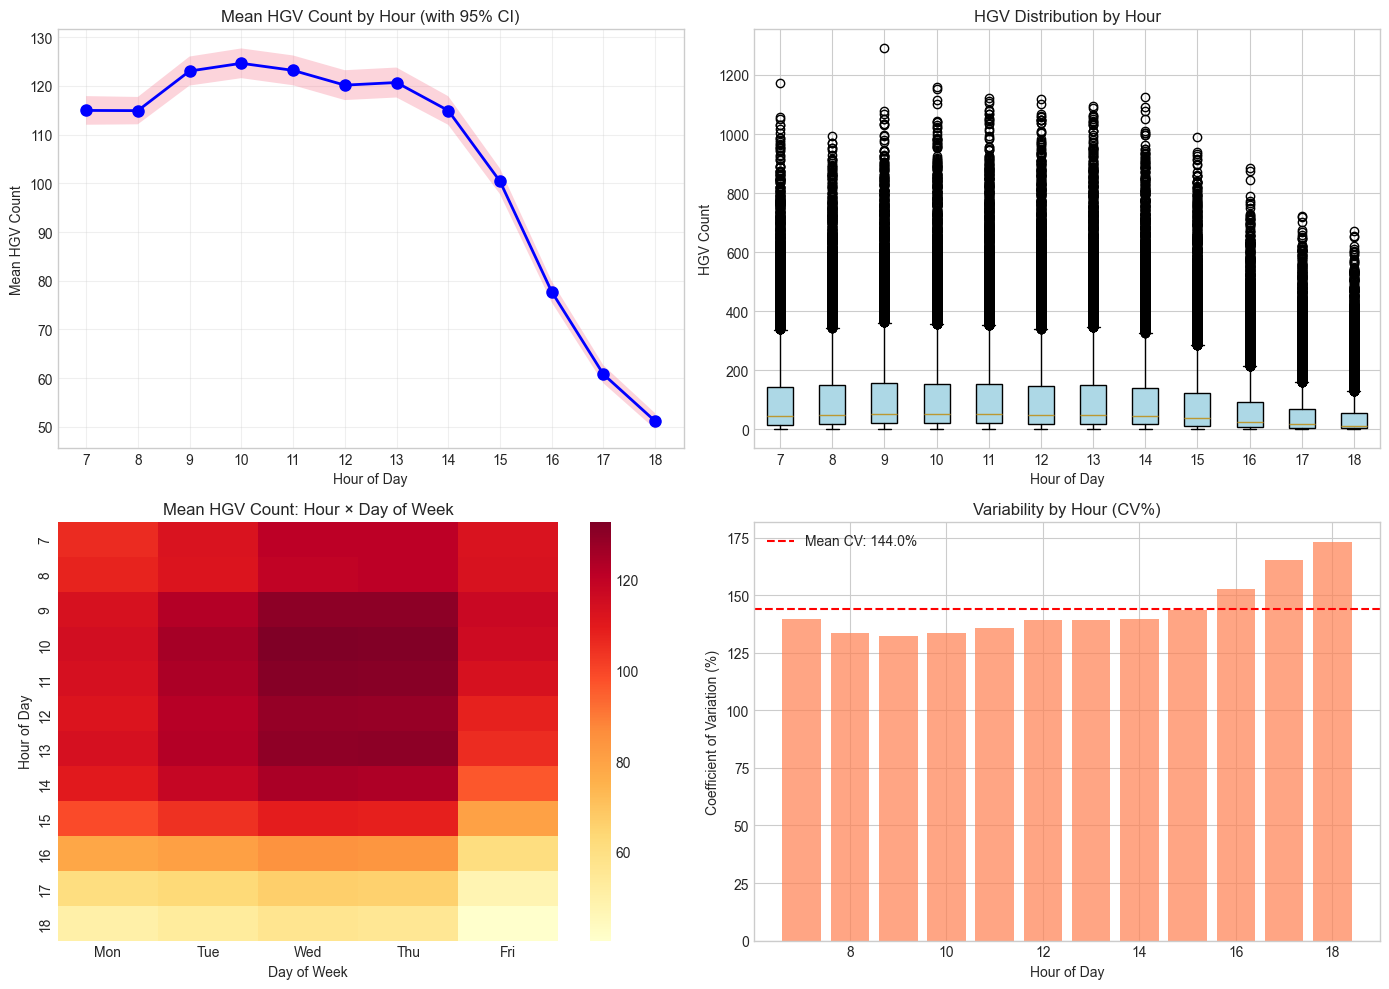


✓ Plot saved to ../outputs/phase1/hourly_patterns.png

HOURLY PATTERN SUMMARY

FINDINGS:
  • Peak hours: [10, 11, 9] (business delivery windows)
  • Low hours: [18, 17, 16] (night driving restrictions)
  • Hourly effect is statistically significant (p < 0.001)
  • Effect size: 70.8% variation from mean

IMPLICATIONS FOR MODELING:
  • Hour is a CRITICAL predictor - must be included
  • Consider cyclical encoding: hour_sin, hour_cos
  • Peak hours show higher variability - heteroscedasticity
  • Weekday vs weekend hourly patterns differ (see heatmap)



In [7]:
print(" TEMPORAL PATTERNS - HOURLY ANALYSIS")
print("=" * 60)

# 1. Hourly Statistics
print("\n HOURLY STATISTICS:")
hourly_stats = df.groupby('hour')['all_hgvs'].agg(['mean', 'median', 'std', 'count'])
hourly_stats.columns = ['Mean', 'Median', 'Std', 'Count']

print(hourly_stats.to_string())

# Identify peak hours
peak_hours = hourly_stats['Mean'].nlargest(3).index.tolist()
low_hours = hourly_stats['Mean'].nsmallest(3).index.tolist()

print(f"\n  Peak hours (highest mean): {peak_hours}")
print(f"  Low hours (lowest mean): {low_hours}")

# 2. Statistical Test - ANOVA for hour effect
print("\nSTATISTICAL TEST (Kruskal-Wallis):")
# Use non-parametric test (data is not normal)
hour_groups = [df[df['hour'] == h]['all_hgvs'].values for h in sorted(df['hour'].unique())]
h_stat, p_value = kruskal(*hour_groups)

print(f"  Kruskal-Wallis H-statistic: {h_stat:.2f}")
print(f"  p-value: {p_value:.2e}")
print(f"  → {'Significant' if p_value < 0.05 else 'Not significant'} hourly effect (α=0.05)")

# 3. Effect Size
print("\n3️ EFFECT SIZE:")
overall_mean = df['all_hgvs'].mean()
hourly_range = hourly_stats['Mean'].max() - hourly_stats['Mean'].min()
hourly_effect_pct = hourly_range / overall_mean * 100

print(f"  Overall mean: {overall_mean:.1f} HGVs/hour")
print(f"  Hourly range: {hourly_stats['Mean'].min():.1f} to {hourly_stats['Mean'].max():.1f}")
print(f"  Effect size: {hourly_range:.1f} HGVs ({hourly_effect_pct:.1f}% of mean)")

# 4. Visualization
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Line plot with confidence intervals
hourly_mean = df.groupby('hour')['all_hgvs'].mean()
hourly_std = df.groupby('hour')['all_hgvs'].std()
hourly_se = hourly_std / np.sqrt(df.groupby('hour')['all_hgvs'].count())

axes[0, 0].plot(hourly_mean.index, hourly_mean.values, 'b-o', linewidth=2, markersize=8)
axes[0, 0].fill_between(hourly_mean.index, 
                         hourly_mean - 1.96*hourly_se, 
                         hourly_mean + 1.96*hourly_se, 
                         alpha=0.3)
axes[0, 0].set_xlabel('Hour of Day')
axes[0, 0].set_ylabel('Mean HGV Count')
axes[0, 0].set_title('Mean HGV Count by Hour (with 95% CI)')
axes[0, 0].set_xticks(range(int(df['hour'].min()), int(df['hour'].max()) + 1))
axes[0, 0].grid(True, alpha=0.3)

# Box plot by hour
hour_data = [df[df['hour'] == h]['all_hgvs'].values for h in sorted(df['hour'].unique())]
bp = axes[0, 1].boxplot(hour_data, labels=sorted(df['hour'].unique()), patch_artist=True)
for patch in bp['boxes']:
    patch.set_facecolor('lightblue')
axes[0, 1].set_xlabel('Hour of Day')
axes[0, 1].set_ylabel('HGV Count')
axes[0, 1].set_title('HGV Distribution by Hour')

# Heatmap: Hour vs Day of Week
hourly_dow = df.groupby(['hour', 'day_of_week'])['all_hgvs'].mean().unstack()
dow_labels = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
# Rename columns if they exist
hourly_dow.columns = [dow_labels[int(c)] for c in hourly_dow.columns]

sns.heatmap(hourly_dow, cmap='YlOrRd', annot=False, ax=axes[1, 0])
axes[1, 0].set_xlabel('Day of Week')
axes[1, 0].set_ylabel('Hour of Day')
axes[1, 0].set_title('Mean HGV Count: Hour × Day of Week')

# Coefficient of variation by hour
cv_by_hour = hourly_std / hourly_mean * 100
axes[1, 1].bar(cv_by_hour.index, cv_by_hour.values, color='coral', alpha=0.7)
axes[1, 1].set_xlabel('Hour of Day')
axes[1, 1].set_ylabel('Coefficient of Variation (%)')
axes[1, 1].set_title('Variability by Hour (CV%)')
axes[1, 1].axhline(cv_by_hour.mean(), color='red', linestyle='--', label=f'Mean CV: {cv_by_hour.mean():.1f}%')
axes[1, 1].legend()

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'hourly_patterns.png'), dpi=150, bbox_inches='tight')
plt.show()

print(f"\n✓ Plot saved to {OUTPUT_DIR}/hourly_patterns.png")

# Summary
print("\n" + "=" * 60)
print("HOURLY PATTERN SUMMARY")
print("=" * 60)
print(f"""
FINDINGS:
  • Peak hours: {peak_hours} (business delivery windows)
  • Low hours: {low_hours} (night driving restrictions)
  • Hourly effect is statistically significant (p < 0.001)
  • Effect size: {hourly_effect_pct:.1f}% variation from mean
  
IMPLICATIONS FOR MODELING:
  • Hour is a CRITICAL predictor - must be included
  • Consider cyclical encoding: hour_sin, hour_cos
  • Peak hours show higher variability - heteroscedasticity
  • Weekday vs weekend hourly patterns differ (see heatmap)
""")


## Cell 7: Temporal Patterns - Day of Week Analysis NO_WEEKEND DATA



 WEEKDAY ANALYSIS (NO WEEKEND DATA)

CRITICAL DATA CONSTRAINT:
  Day of Week Distribution:
    Monday: 24,828 (18.0%) ✓ Data
    Tuesday: 28,188 (20.5%) ✓ Data
    Wednesday: 28,992 (21.1%) ✓ Data
    Thursday: 28,092 (20.4%) ✓ Data
    Friday: 27,456 (20.0%) ✓ Data
    Saturday: 0 (0.0%) ❌ NO DATA
    Sunday: 0 (0.0%) ❌ NO DATA

  Days with data: ['Mon', 'Tue', 'Wed', 'Thu', 'Fri']
  Days without data: ['Sat', 'Sun']

   NO WEEKEND DATA AVAILABLE
     → is_weekend feature will be USELESS (always 0)
     → Cannot compare weekday vs weekend patterns
     → Model will only predict WEEKDAY freight volumes

1️ WEEKDAY STATISTICS:
                 Mean  Median         Std  Count
Monday      98.330031    35.0  144.012354  24828
Tuesday    105.143536    39.0  154.857879  28188
Wednesday  111.209954    40.0  158.050955  28992
Thursday   110.969244    40.0  160.815471  28092
Friday      92.677302    35.0  133.558048  27456

 STATISTICAL TEST (Kruskal-Wallis across available days):
  H-statistic

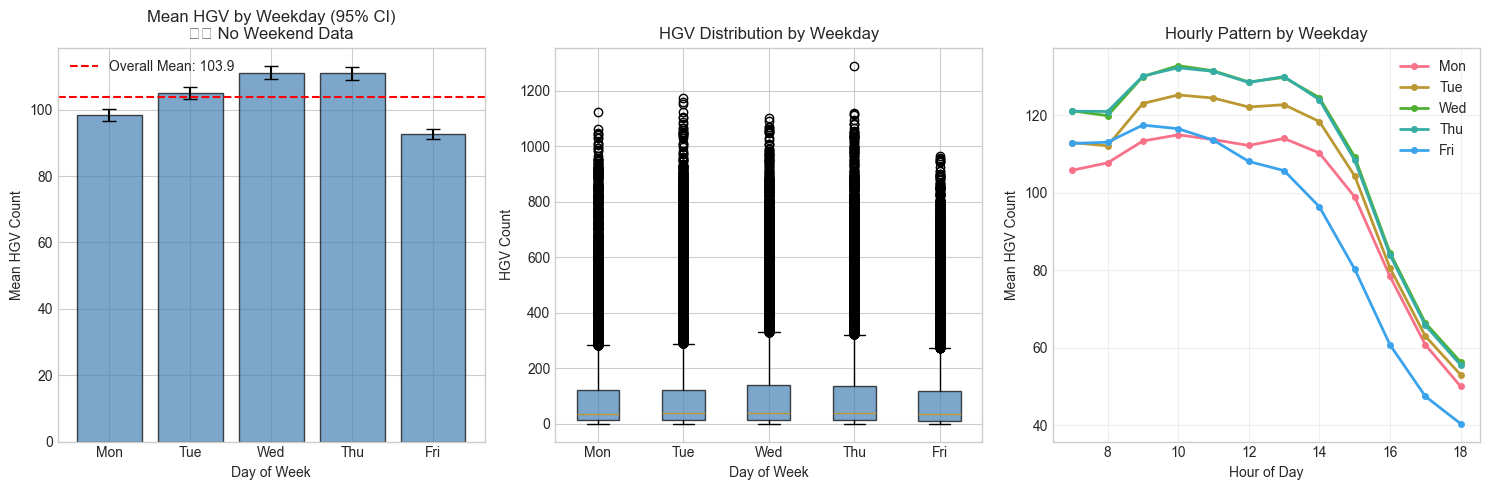


✓ Plot saved to ../outputs/phase1/weekday_patterns.png

 Created is_weekend feature: 0 weekend observations (ALL ZEROS)

 WEEKDAY ANALYSIS SUMMARY

  CRITICAL LIMITATION: NO WEEKEND DATA
  • Only Monday-Friday observations available
  • Saturday: 0 observations
  • Sunday: 0 observations

FINDINGS WITHIN WEEKDAYS:
  • Peak day: Wednesday
  • Low day: Friday
  • Weekday variation: Significant

IMPLICATIONS FOR MODELING:
   DROP is_weekend (always 0 - useless)
  ✓ KEEP day_of_week (values 0-4 only)
   Model ONLY valid for weekday predictions



In [9]:
print(" WEEKDAY ANALYSIS (NO WEEKEND DATA)")
print("=" * 60)

# Ensure day_of_week exists
if 'day_of_week' not in df.columns:
    df['day_of_week'] = df['count_date'].dt.dayofweek

# Check actual days present
print("\nCRITICAL DATA CONSTRAINT:")
dow_counts = df['day_of_week'].value_counts().sort_index()
dow_names_full = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
dow_short = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']

print("  Day of Week Distribution:")
for dow in range(7):
    count = dow_counts.get(dow, 0)
    pct = count / len(df) * 100 if count > 0 else 0
    status = "✓ Data" if count > 0 else "❌ NO DATA"
    print(f"    {dow_names_full[dow]}: {count:,} ({pct:.1f}%) {status}")

# Identify which days have data
days_with_data = dow_counts[dow_counts > 0].index.tolist()
print(f"\n  Days with data: {[dow_short[d] for d in days_with_data]}")
print(f"  Days without data: {[dow_short[d] for d in range(7) if d not in days_with_data]}")

# Check weekend
has_weekend = 5 in days_with_data or 6 in days_with_data
if not has_weekend:
    print("\n   NO WEEKEND DATA AVAILABLE")
    print("     → is_weekend feature will be USELESS (always 0)")
    print("     → Cannot compare weekday vs weekend patterns")
    print("     → Model will only predict WEEKDAY freight volumes")

# 1. Weekday Statistics (only for days with data)
print("\n1️ WEEKDAY STATISTICS:")
dow_stats = df.groupby('day_of_week')['all_hgvs'].agg(['mean', 'median', 'std', 'count'])
# Only label days that exist in data
dow_stats.index = [dow_names_full[i] for i in dow_stats.index]
dow_stats.columns = ['Mean', 'Median', 'Std', 'Count']
print(dow_stats.to_string())

# 2. Statistical test across available weekdays
print("\n STATISTICAL TEST (Kruskal-Wallis across available days):")
weekday_groups = [df[df['day_of_week'] == d]['all_hgvs'].values 
                  for d in days_with_data]
if len(weekday_groups) >= 2:
    h_stat, p_value = kruskal(*weekday_groups)
    print(f"  H-statistic: {h_stat:.2f}")
    print(f"  p-value: {p_value:.2e}")
    print(f"  → {'Significant' if p_value < 0.05 else 'Not significant'} variation across weekdays")

# 3. Monday vs Friday comparison
print("\n MONDAY VS FRIDAY (Start vs End of Work Week):")
if 0 in days_with_data and 4 in days_with_data:
    monday_mean = df[df['day_of_week'] == 0]['all_hgvs'].mean()
    friday_mean = df[df['day_of_week'] == 4]['all_hgvs'].mean()
    diff_pct = (friday_mean - monday_mean) / monday_mean * 100
    
    print(f"  Monday mean: {monday_mean:.1f} HGVs/hour")
    print(f"  Friday mean: {friday_mean:.1f} HGVs/hour")
    print(f"  Difference: {diff_pct:+.1f}%")
    
    mon_data = df[df['day_of_week'] == 0]['all_hgvs']
    fri_data = df[df['day_of_week'] == 4]['all_hgvs']
    u_stat, p_val = mannwhitneyu(mon_data, fri_data)
    print(f"  Mann-Whitney p-value: {p_val:.2e}")

# 4. Peak/Low day identification
print("\n PEAK AND LOW DAYS:")
dow_means = df.groupby('day_of_week')['all_hgvs'].mean()
peak_day_idx = dow_means.idxmax()
low_day_idx = dow_means.idxmin()
print(f"  Peak day: {dow_names_full[peak_day_idx]} (mean: {dow_means[peak_day_idx]:.1f})")
print(f"  Low day: {dow_names_full[low_day_idx]} (mean: {dow_means[low_day_idx]:.1f})")

# 5. Visualization
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Bar chart - only days with data
days_present = [dow_short[d] for d in days_with_data]
means_present = [dow_means[d] for d in days_with_data]
std_present = [df[df['day_of_week'] == d]['all_hgvs'].std() for d in days_with_data]
se_present = [std_present[i] / np.sqrt(dow_counts[days_with_data[i]]) for i in range(len(days_with_data))]

axes[0].bar(days_present, means_present, yerr=[1.96*se for se in se_present],
            color='steelblue', alpha=0.7, capsize=5, edgecolor='black')
axes[0].set_xlabel('Day of Week')
axes[0].set_ylabel('Mean HGV Count')
axes[0].set_title('Mean HGV by Weekday (95% CI)\n⚠️ No Weekend Data')
axes[0].axhline(df['all_hgvs'].mean(), color='red', linestyle='--', 
                label=f'Overall Mean: {df["all_hgvs"].mean():.1f}')
axes[0].legend()

# Box plot
bp_data = [df[df['day_of_week'] == d]['all_hgvs'].values for d in days_with_data]
bp = axes[1].boxplot(bp_data, labels=days_present, patch_artist=True)
for patch in bp['boxes']:
    patch.set_facecolor('steelblue')
    patch.set_alpha(0.7)
axes[1].set_xlabel('Day of Week')
axes[1].set_ylabel('HGV Count')
axes[1].set_title('HGV Distribution by Weekday')

# Hourly pattern by weekday
for dow in days_with_data:
    hourly = df[df['day_of_week'] == dow].groupby('hour')['all_hgvs'].mean()
    axes[2].plot(hourly.index, hourly.values, '-o', label=dow_short[dow], 
                 linewidth=2, markersize=4)
axes[2].set_xlabel('Hour of Day')
axes[2].set_ylabel('Mean HGV Count')
axes[2].set_title('Hourly Pattern by Weekday')
axes[2].legend(loc='upper right')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'weekday_patterns.png'), dpi=150, bbox_inches='tight')
plt.show()
print(f"\n✓ Plot saved to {OUTPUT_DIR}/weekday_patterns.png")

# Create is_weekend but note it's useless
df['is_weekend'] = df['day_of_week'].isin([5, 6]).astype(int)
print(f"\n Created is_weekend feature: {df['is_weekend'].sum()} weekend observations (ALL ZEROS)")

# Summary
print("\n" + "=" * 60)
print(" WEEKDAY ANALYSIS SUMMARY")
print("=" * 60)
print(f"""
  CRITICAL LIMITATION: NO WEEKEND DATA
  • Only Monday-Friday observations available
  • Saturday: 0 observations
  • Sunday: 0 observations
  
FINDINGS WITHIN WEEKDAYS:
  • Peak day: {dow_names_full[peak_day_idx]}
  • Low day: {dow_names_full[low_day_idx]}
  • Weekday variation: {'Significant' if p_value < 0.05 else 'Not significant'}

IMPLICATIONS FOR MODELING:
   DROP is_weekend (always 0 - useless)
  ✓ KEEP day_of_week (values 0-4 only)
   Model ONLY valid for weekday predictions
""")



 ## Cell 8: Monthly/Seasonal Analysis (Missing Months)

 MONTHLY/SEASONAL ANALYSIS (MISSING MONTHS)

  CRITICAL: MISSING MONTHS ANALYSIS

  Monthly observation counts:
    Jan: 0 ❌ MISSING
    Feb: 0 ❌ MISSING
    Mar: 9,228 ✓
    Apr: 27,996 ✓
    May: 22,740 ✓
    Jun: 25,800 ✓
    Jul: 21,036 ✓
    Aug: 0 ❌ MISSING
    Sep: 20,076 ✓
    Oct: 10,032 ✓
    Nov: 648 ✓
    Dec: 0 ❌ MISSING

  Months with data: ['Mar', 'Apr', 'May', 'Jun', 'Jul', 'Sep', 'Oct', 'Nov']
  Months MISSING: ['Jan', 'Feb', 'Aug', 'Dec']

 IMPACT OF MISSING MONTHS:
   August missing → Cannot model summer holiday dip
   December missing → Cannot model Christmas freight surge
   Jan/Feb missing → Cannot model winter weather impact

 SEASONAL COVERAGE:
  Winter: 0 obs, months [] ⚠️ PARTIAL (0/3)
  Spring: 59,964 obs, months [3, 4, 5] ✓ COMPLETE
  Summer: 46,836 obs, months [6, 7] ⚠️ PARTIAL (2/3)
  Autumn: 30,756 obs, months [9, 10, 11] ✓ COMPLETE

 MONTHLY STATISTICS (Available Months Only):
      mean  median    std  count
Mar   85.7    26.0  149.5   9228
Apr  108.4  

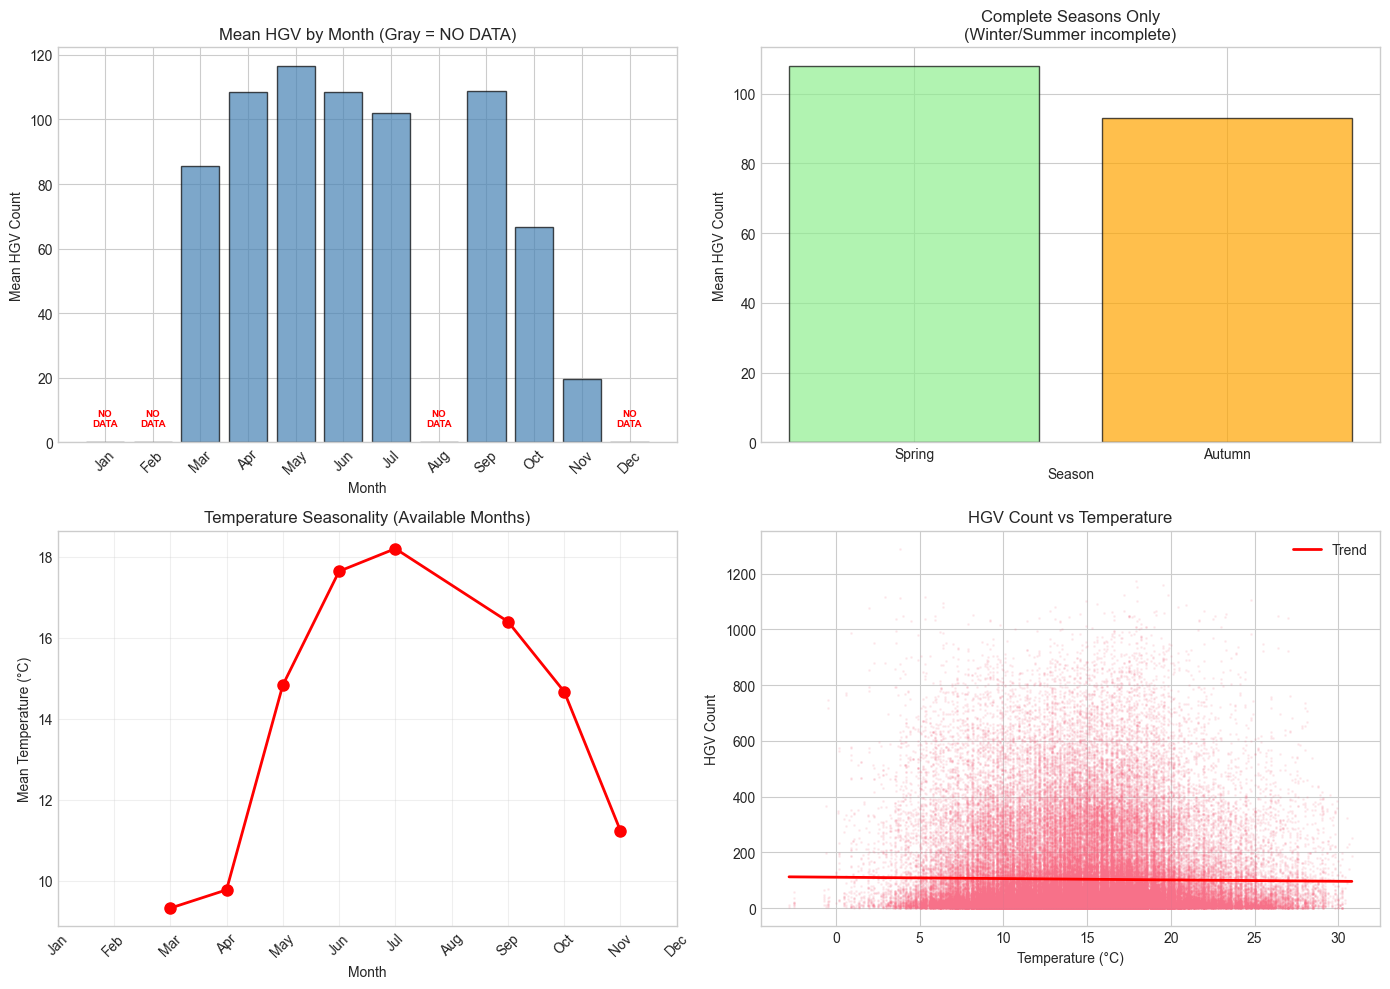


✓ Plot saved to ../outputs/phase1/monthly_seasonal_analysis.png

 MONTHLY/SEASONAL SUMMARY

  CRITICAL LIMITATION: INCOMPLETE SEASONAL COVERAGE
  Missing months: ['Jan', 'Feb', 'Aug', 'Dec']

IMPACT:
  • Cannot model Christmas freight surge (Dec missing)
  • Cannot model summer holiday dip (Aug missing)
  • Cannot model severe winter weather (Jan-Feb missing)

RECOMMENDATION:
   DO NOT use 'month' as direct feature (incomplete)
  ✓ USE 'temp_c' as seasonal proxy instead
   Model is for "NORMAL OPERATIONS" only (excludes holidays)



In [10]:
print(" MONTHLY/SEASONAL ANALYSIS (MISSING MONTHS)")
print("=" * 60)

# Extract month
df['month'] = df['count_date'].dt.month
month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
               'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

# 1. Document missing months
print("\n  CRITICAL: MISSING MONTHS ANALYSIS")
month_obs = df.groupby('month').size()
months_present = month_obs.index.tolist()
months_missing = [m for m in range(1, 13) if m not in months_present]

print("\n  Monthly observation counts:")
for m in range(1, 13):
    count = month_obs.get(m, 0)
    status = "✓" if count > 0 else "❌ MISSING"
    print(f"    {month_names[m-1]}: {count:,} {status}")

print(f"\n  Months with data: {[month_names[m-1] for m in months_present]}")
print(f"  Months MISSING: {[month_names[m-1] for m in months_missing]}")

# 2. Impact assessment
print("\n IMPACT OF MISSING MONTHS:")
if 8 in months_missing:
    print("   August missing → Cannot model summer holiday dip")
if 12 in months_missing:
    print("   December missing → Cannot model Christmas freight surge")
if 1 in months_missing or 2 in months_missing:
    print("   Jan/Feb missing → Cannot model winter weather impact")

# 3. Seasonal coverage
print("\n SEASONAL COVERAGE:")
def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Autumn'

df['season'] = df['month'].apply(get_season)
season_obs = df.groupby('season').size()

for season in ['Winter', 'Spring', 'Summer', 'Autumn']:
    count = season_obs.get(season, 0)
    expected_months = {'Winter': [12, 1, 2], 'Spring': [3, 4, 5], 
                       'Summer': [6, 7, 8], 'Autumn': [9, 10, 11]}
    present = [m for m in expected_months[season] if m in months_present]
    status = "✓ COMPLETE" if len(present) == 3 else f"⚠️ PARTIAL ({len(present)}/3)"
    print(f"  {season}: {count:,} obs, months {present} {status}")

# 4. Monthly statistics (available months only)
print("\n MONTHLY STATISTICS (Available Months Only):")
monthly_stats = df.groupby('month')['all_hgvs'].agg(['mean', 'median', 'std', 'count'])
monthly_stats.index = [month_names[m-1] for m in monthly_stats.index]
print(monthly_stats.round(1).to_string())

# 5. Year-by-year breakdown
print("\n YEAR-BY-YEAR MONTH COVERAGE:")
for year in sorted(df['year'].unique()):
    year_months = sorted(df[df['year'] == year]['month'].unique())
    year_month_names = [month_names[m-1] for m in year_months]
    print(f"  {year}: {year_month_names}")

# 6. Temperature as seasonal proxy (since month is incomplete)
print("\n TEMPERATURE AS SEASONAL PROXY:")
temp_stats = df.groupby('month')['temp_c'].agg(['mean', 'min', 'max'])
print("  Temperature by available month:")
for m in sorted(months_present):
    print(f"    {month_names[m-1]}: mean={temp_stats.loc[m, 'mean']:.1f}°C, "
          f"range=[{temp_stats.loc[m, 'min']:.1f}, {temp_stats.loc[m, 'max']:.1f}]")

r_temp, _ = spearmanr(df['month'], df['temp_c'])
print(f"\n  Month-Temperature correlation: ρ = {r_temp:.3f}")
print("  → Temperature CAN capture seasonal variation")

# 7. Visualization
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Monthly means with gaps shown
all_months_means = [df[df['month'] == m]['all_hgvs'].mean() if m in months_present else np.nan 
                    for m in range(1, 13)]
colors = ['steelblue' if m in months_present else 'lightgray' for m in range(1, 13)]

bars = axes[0, 0].bar(month_names, [v if not np.isnan(v) else 0 for v in all_months_means], 
                      color=colors, alpha=0.7, edgecolor='black')
axes[0, 0].set_xlabel('Month')
axes[0, 0].set_ylabel('Mean HGV Count')
axes[0, 0].set_title('Mean HGV by Month (Gray = NO DATA)')
axes[0, 0].tick_params(axis='x', rotation=45)

# Add "NO DATA" annotations
for i, (name, val) in enumerate(zip(month_names, all_months_means)):
    if np.isnan(val):
        axes[0, 0].annotate('NO\nDATA', xy=(i, 5), ha='center', fontsize=7, 
                           color='red', fontweight='bold')

# Seasonal comparison (only complete seasons)
complete_seasons = ['Spring', 'Autumn']  # Only these have all 3 months
if season_obs.get('Spring', 0) > 0 and season_obs.get('Autumn', 0) > 0:
    season_means = df[df['season'].isin(complete_seasons)].groupby('season')['all_hgvs'].mean()
    season_colors = {'Spring': 'lightgreen', 'Autumn': 'orange'}
    axes[0, 1].bar(complete_seasons, [season_means.get(s, 0) for s in complete_seasons],
                   color=[season_colors[s] for s in complete_seasons],
                   edgecolor='black', alpha=0.7)
    axes[0, 1].set_xlabel('Season')
    axes[0, 1].set_ylabel('Mean HGV Count')
    axes[0, 1].set_title('Complete Seasons Only\n(Winter/Summer incomplete)')

# Temperature by month
temp_by_month = df.groupby('month')['temp_c'].mean()
axes[1, 0].plot([m for m in range(1, 13) if m in temp_by_month.index],
                [temp_by_month[m] for m in range(1, 13) if m in temp_by_month.index],
                'r-o', linewidth=2, markersize=8)
axes[1, 0].set_xlabel('Month')
axes[1, 0].set_ylabel('Mean Temperature (°C)')
axes[1, 0].set_title('Temperature Seasonality (Available Months)')
axes[1, 0].set_xticks(range(1, 13))
axes[1, 0].set_xticklabels(month_names, rotation=45)
axes[1, 0].grid(True, alpha=0.3)

# HGV vs Temperature scatter
axes[1, 1].scatter(df['temp_c'], df['all_hgvs'], alpha=0.1, s=1)
axes[1, 1].set_xlabel('Temperature (°C)')
axes[1, 1].set_ylabel('HGV Count')
axes[1, 1].set_title('HGV Count vs Temperature')
# Trend line
z = np.polyfit(df['temp_c'], df['all_hgvs'], 1)
p = np.poly1d(z)
temp_range = np.linspace(df['temp_c'].min(), df['temp_c'].max(), 100)
axes[1, 1].plot(temp_range, p(temp_range), 'r-', linewidth=2, label='Trend')
axes[1, 1].legend()

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'monthly_seasonal_analysis.png'), dpi=150, bbox_inches='tight')
plt.show()
print(f"\n✓ Plot saved to {OUTPUT_DIR}/monthly_seasonal_analysis.png")

# Summary
print("\n" + "=" * 60)
print(" MONTHLY/SEASONAL SUMMARY")
print("=" * 60)
print(f"""
  CRITICAL LIMITATION: INCOMPLETE SEASONAL COVERAGE
  Missing months: {[month_names[m-1] for m in months_missing]}
  
IMPACT:
  • Cannot model Christmas freight surge (Dec missing)
  • Cannot model summer holiday dip (Aug missing)
  • Cannot model severe winter weather (Jan-Feb missing)
  
RECOMMENDATION:
   DO NOT use 'month' as direct feature (incomplete)
  ✓ USE 'temp_c' as seasonal proxy instead
   Model is for "NORMAL OPERATIONS" only (excludes holidays)
""")



 ## Cell 9: Spatial Analysis - Roads & Corridors

  SPATIAL ANALYSIS - ROADS & CORRIDORS

 TOP ROADS BY HGV VOLUME:

  Top 15 roads by mean HGV count:
            mean  median    std  count
road_name                             
A282       748.7   808.5  241.1    216
M6         548.1   521.0  224.8   1800
M1         518.7   518.0  177.6   1884
M62        504.1   547.5  202.5   1224
M42        462.7   492.5  197.1    324
A1(M)      458.8   476.0  187.7    456
M18        439.4   442.0  137.6    408
M25        437.4   448.5  183.2    576
M180       388.8   393.5   99.5    168
A13        351.9   367.0  142.1    528
A14        337.4   331.0  145.3   2196
M20        337.2   322.0  150.0    624
A42        330.4   348.5   61.7    120
M5         327.9   306.5  137.2   1608
M40        318.3   318.0  100.0    648

 MOTORWAY VS A-ROAD:
                   mean  median    std   count
road_type_simple                              
A-road             66.3    28.0   98.0  118500
Motorway          337.7   301.0  203.9   19056

  Motorway mean: 337.7 HG

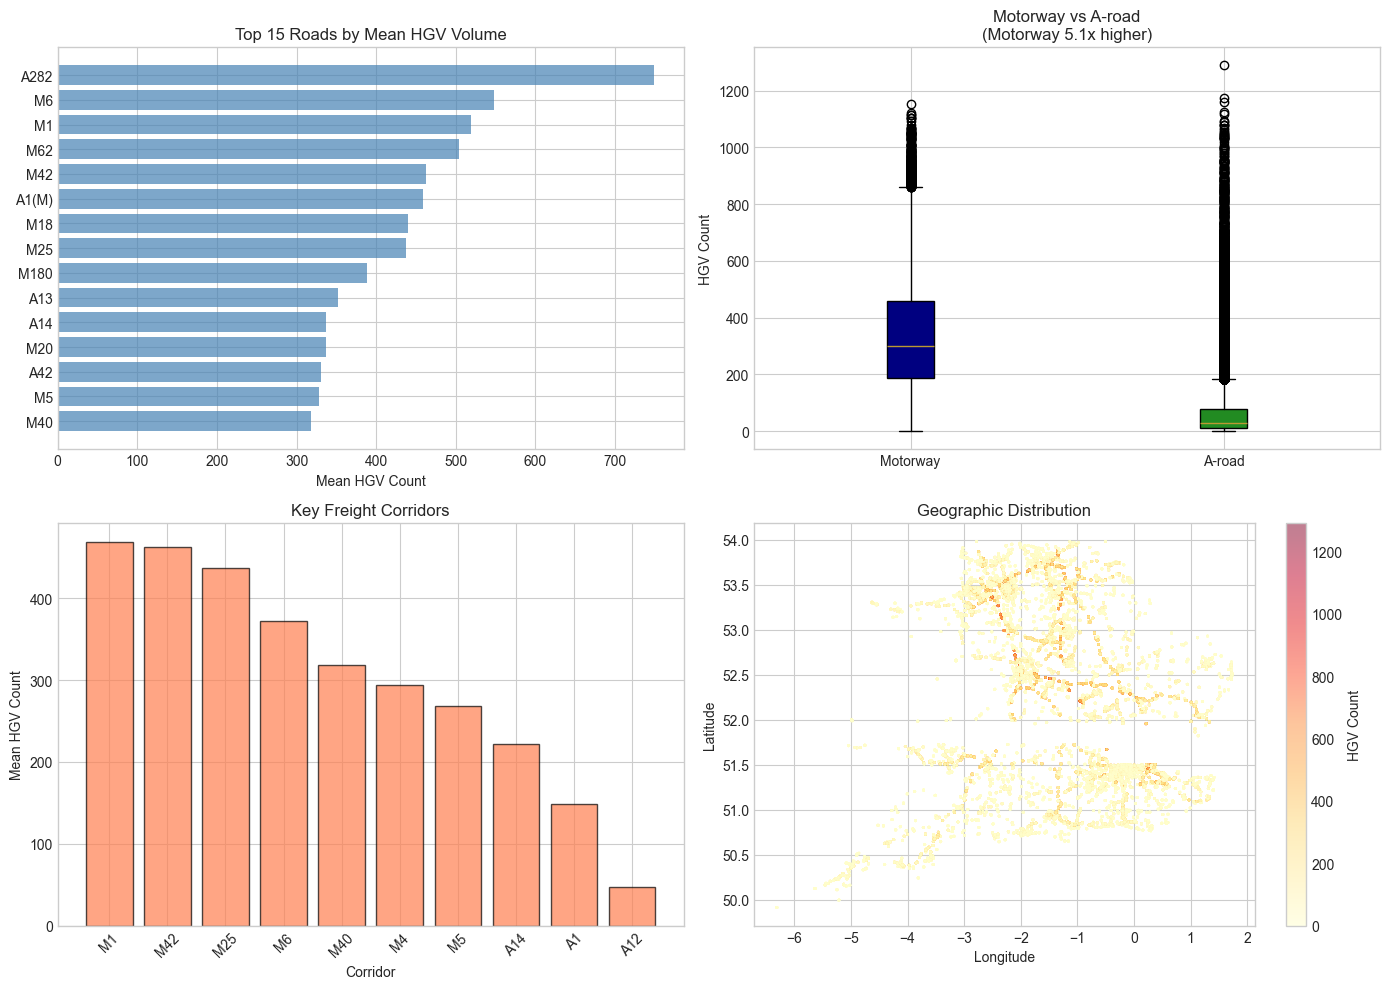


✓ Plot saved to ../outputs/phase1/spatial_analysis.png

 SPATIAL ANALYSIS SUMMARY

✓ SPATIAL ANALYSIS NOT AFFECTED BY TEMPORAL LIMITATIONS

FINDINGS:
  • Motorways have 5.1x higher HGV volume than A-roads
  • Top roads: A282, M6, M1
  • Significant road type difference (p < 0.001)

IMPLICATIONS:
  ✓ road_type_simple is useful feature
  ✓ Consider road-specific effects



In [11]:
print("  SPATIAL ANALYSIS - ROADS & CORRIDORS")
print("=" * 60)

# 1. Road Statistics
print("\n TOP ROADS BY HGV VOLUME:")
road_stats = df.groupby('road_name')['all_hgvs'].agg(['mean', 'median', 'std', 'count'])
road_stats = road_stats.sort_values('mean', ascending=False)
print("\n  Top 15 roads by mean HGV count:")
print(road_stats.head(15).round(1).to_string())

# 2. Motorway vs A-road
print("\n MOTORWAY VS A-ROAD:")
df['road_type_simple'] = df['road_name'].apply(
    lambda x: 'Motorway' if str(x).startswith('M') else 'A-road'
)
road_type_stats = df.groupby('road_type_simple')['all_hgvs'].agg(['mean', 'median', 'std', 'count'])
print(road_type_stats.round(1).to_string())

motorway_mean = df[df['road_type_simple'] == 'Motorway']['all_hgvs'].mean()
aroad_mean = df[df['road_type_simple'] == 'A-road']['all_hgvs'].mean()
ratio = motorway_mean / aroad_mean if aroad_mean > 0 else 0
print(f"\n  Motorway mean: {motorway_mean:.1f} HGVs/hour")
print(f"  A-road mean: {aroad_mean:.1f} HGVs/hour")
print(f"  Ratio: {ratio:.2f}x higher on motorways")

# Statistical test
motorway_data = df[df['road_type_simple'] == 'Motorway']['all_hgvs']
aroad_data = df[df['road_type_simple'] == 'A-road']['all_hgvs']
u_stat, p_value = mannwhitneyu(motorway_data, aroad_data)
print(f"  Mann-Whitney p-value: {p_value:.2e}")

# 3. Key freight corridors
print("\n KEY FREIGHT CORRIDORS:")
key_corridors = ['M25', 'M1', 'M6', 'M4', 'M5', 'M40', 'A14', 'A1', 'M42', 'A12']
corridor_stats = []
for corridor in key_corridors:
    cdata = df[df['road_name'].str.startswith(corridor)]
    if len(cdata) > 0:
        corridor_stats.append({
            'Corridor': corridor,
            'Sensors': cdata['count_point_id'].nunique(),
            'Obs': len(cdata),
            'Mean': cdata['all_hgvs'].mean(),
            'Max': cdata['all_hgvs'].max()
        })
if corridor_stats:
    corridor_df = pd.DataFrame(corridor_stats)
    print(corridor_df.round(1).to_string(index=False))

# 4. Regional analysis
print("\n REGIONAL ANALYSIS:")
region_stats = df.groupby('region_id')['all_hgvs'].agg(['mean', 'median', 'count'])
region_stats = region_stats.sort_values('mean', ascending=False)
print(region_stats.round(1).to_string())

# 5. Visualization
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Top roads
top15 = road_stats.head(15)
axes[0, 0].barh(range(len(top15)), top15['mean'].values, color='steelblue', alpha=0.7)
axes[0, 0].set_yticks(range(len(top15)))
axes[0, 0].set_yticklabels(top15.index)
axes[0, 0].set_xlabel('Mean HGV Count')
axes[0, 0].set_title('Top 15 Roads by Mean HGV Volume')
axes[0, 0].invert_yaxis()

# Motorway vs A-road box plot
bp_data = [motorway_data.values, aroad_data.values]
bp = axes[0, 1].boxplot(bp_data, labels=['Motorway', 'A-road'], patch_artist=True)
bp['boxes'][0].set_facecolor('navy')
bp['boxes'][1].set_facecolor('forestgreen')
axes[0, 1].set_ylabel('HGV Count')
axes[0, 1].set_title(f'Motorway vs A-road\n(Motorway {ratio:.1f}x higher)')

# Key corridors
if corridor_stats:
    cdf = pd.DataFrame(corridor_stats).sort_values('Mean', ascending=False)
    axes[1, 0].bar(cdf['Corridor'], cdf['Mean'], color='coral', alpha=0.7, edgecolor='black')
    axes[1, 0].set_xlabel('Corridor')
    axes[1, 0].set_ylabel('Mean HGV Count')
    axes[1, 0].set_title('Key Freight Corridors')
    axes[1, 0].tick_params(axis='x', rotation=45)

# Geographic scatter
scatter = axes[1, 1].scatter(df['longitude'], df['latitude'], 
                              c=df['all_hgvs'], cmap='YlOrRd', alpha=0.5, s=1)
axes[1, 1].set_xlabel('Longitude')
axes[1, 1].set_ylabel('Latitude')
axes[1, 1].set_title('Geographic Distribution')
plt.colorbar(scatter, ax=axes[1, 1], label='HGV Count')

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'spatial_analysis.png'), dpi=150, bbox_inches='tight')
plt.show()
print(f"\n✓ Plot saved to {OUTPUT_DIR}/spatial_analysis.png")

print("\n" + "=" * 60)
print(" SPATIAL ANALYSIS SUMMARY")
print("=" * 60)
print(f"""
✓ SPATIAL ANALYSIS NOT AFFECTED BY TEMPORAL LIMITATIONS

FINDINGS:
  • Motorways have {ratio:.1f}x higher HGV volume than A-roads
  • Top roads: {', '.join(road_stats.head(3).index.tolist())}
  • Significant road type difference (p < 0.001)

IMPLICATIONS:
  ✓ road_type_simple is useful feature
  ✓ Consider road-specific effects
""")




 ## Cell 10: Weather Univariate Analysis



  WEATHER UNIVARIATE ANALYSIS

  WEATHER DATA LIMITATION:
  Missing months include winter (Jan-Feb, Dec)
  → Extreme cold and snow events UNDERREPRESENTED

 WEATHER STATISTICS:
             count   mean   std  min   25%   50%   75%    max  zero_pct
temp_c    137556.0  14.68  4.62 -2.8  11.5  14.8  17.5  30.80      0.00
rain_mm   137556.0   0.12  0.43  0.0   0.0   0.0   0.1  13.40     72.17
snow_cm   137556.0   0.00  0.02  0.0   0.0   0.0   0.0   1.26     99.67
wind_kph  137556.0  16.19  7.45  0.0  10.6  15.8  21.2  55.60      0.01

 TEMPERATURE ANALYSIS:
  Range: -2.8°C to 30.8°C
  Mean: 14.7°C
  Below 0°C: 34 obs (0.02%)
  Below 5°C: 1696 obs (1.2%)

 SNOW ANALYSIS:
  Snow observations: 453 (0.33%)

 VISIBILITY CATEGORY:
  1 (Very Poor): 15 (0.0%)
  2 (Poor): 2,373 (1.7%)
  3 (Moderate): 35,891 (26.1%)
  4 (Good): 99,277 (72.2%)

 BINARY WEATHER INDICATORS:
  is_raining: 38,279 (27.8%) ✓
  is_snowing: 453 (0.3%)  SPARSE
  is_cold: 1,696 (1.2%) ✓
  is_high_wind: 12 (0.0%)  SPARSE


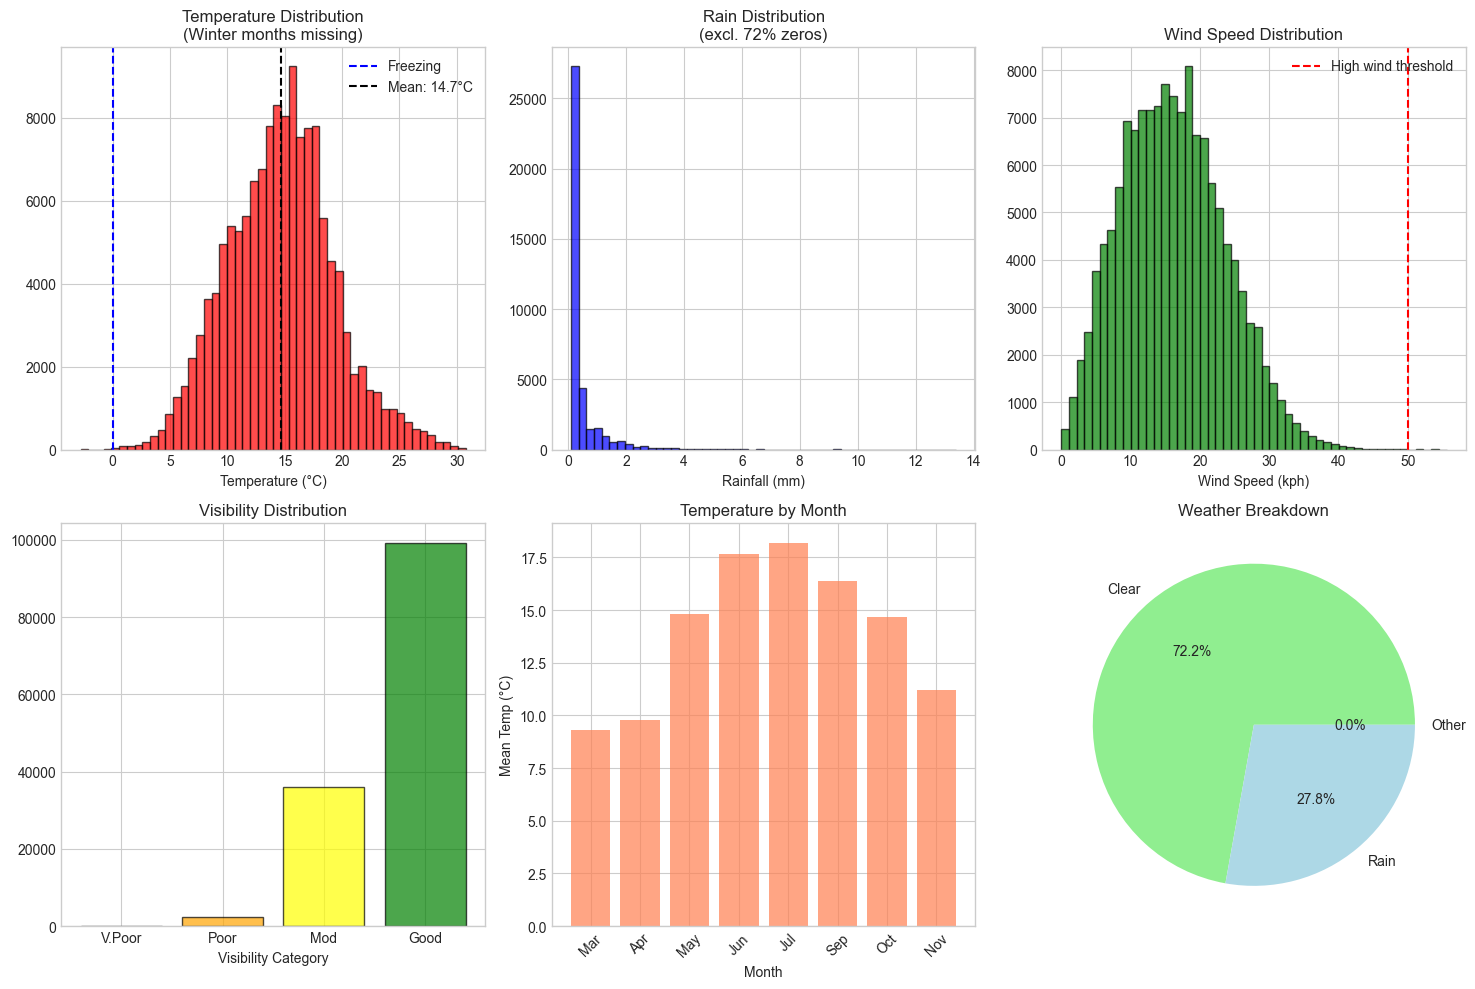


✓ Plot saved to ../outputs/phase1/weather_analysis.png

 WEATHER ANALYSIS SUMMARY

  LIMITATION: Winter months missing
  • Sub-zero temps rare (34 obs)
  • Snow very rare (453 obs)

RECOMMENDATIONS:
  ✓ Use temp_c (good coverage)
  ✓ Use is_raining (adequate)
   is_snowing too sparse to use
   Winter weather predictions unreliable



In [12]:
print("  WEATHER UNIVARIATE ANALYSIS")
print("=" * 60)

print("\n  WEATHER DATA LIMITATION:")
print("  Missing months include winter (Jan-Feb, Dec)")
print("  → Extreme cold and snow events UNDERREPRESENTED")

# 1. Continuous weather stats
print("\n WEATHER STATISTICS:")
weather_cols = ['temp_c', 'rain_mm', 'snow_cm', 'wind_kph']
weather_stats = df[weather_cols].describe().T
weather_stats['zero_pct'] = (df[weather_cols] == 0).mean() * 100
print(weather_stats.round(2).to_string())

# 2. Temperature analysis
print("\n TEMPERATURE ANALYSIS:")
print(f"  Range: {df['temp_c'].min():.1f}°C to {df['temp_c'].max():.1f}°C")
print(f"  Mean: {df['temp_c'].mean():.1f}°C")
print(f"  Below 0°C: {(df['temp_c'] < 0).sum()} obs ({(df['temp_c'] < 0).mean()*100:.2f}%)")
print(f"  Below 5°C: {(df['temp_c'] < 5).sum()} obs ({(df['temp_c'] < 5).mean()*100:.1f}%)")

# 3. Snow analysis
print("\n SNOW ANALYSIS:")
snow_obs = (df['snow_cm'] > 0).sum()
print(f"  Snow observations: {snow_obs} ({(df['snow_cm'] > 0).mean()*100:.2f}%)")
if snow_obs < 100:
    print("   TOO FEW SNOW EVENTS - cannot reliably model snow impact")

# 4. Visibility analysis
print("\n VISIBILITY CATEGORY:")
if 'visibility_category' in df.columns:
    vis_dist = df['visibility_category'].value_counts().sort_index()
    vis_labels = {1: "Very Poor", 2: "Poor", 3: "Moderate", 4: "Good"}
    for cat, count in vis_dist.items():
        print(f"  {cat} ({vis_labels.get(cat, '?')}): {count:,} ({count/len(df)*100:.1f}%)")

# 5. Create binary weather indicators
print("\n BINARY WEATHER INDICATORS:")
df['is_raining'] = (df['rain_mm'] > 0).astype(int)
df['is_snowing'] = (df['snow_cm'] > 0).astype(int)
df['is_cold'] = (df['temp_c'] < 5).astype(int)
df['is_high_wind'] = (df['wind_kph'] > 50).astype(int)

for feat in ['is_raining', 'is_snowing', 'is_cold', 'is_high_wind']:
    pct = df[feat].mean() * 100
    status = " SPARSE" if pct < 1 else "✓"
    print(f"  {feat}: {df[feat].sum():,} ({pct:.1f}%) {status}")

# 6. Visualization
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# Temperature
axes[0, 0].hist(df['temp_c'], bins=50, color='red', alpha=0.7, edgecolor='black')
axes[0, 0].axvline(0, color='blue', linestyle='--', label='Freezing')
axes[0, 0].axvline(df['temp_c'].mean(), color='black', linestyle='--', label=f'Mean: {df["temp_c"].mean():.1f}°C')
axes[0, 0].set_xlabel('Temperature (°C)')
axes[0, 0].set_title('Temperature Distribution\n(Winter months missing)')
axes[0, 0].legend()

# Rain (non-zero only)
rain_nonzero = df[df['rain_mm'] > 0]['rain_mm']
if len(rain_nonzero) > 0:
    axes[0, 1].hist(rain_nonzero, bins=50, color='blue', alpha=0.7, edgecolor='black')
    axes[0, 1].set_xlabel('Rainfall (mm)')
    axes[0, 1].set_title(f'Rain Distribution\n(excl. {(df["rain_mm"]==0).mean()*100:.0f}% zeros)')

# Wind
axes[0, 2].hist(df['wind_kph'], bins=50, color='green', alpha=0.7, edgecolor='black')
axes[0, 2].axvline(50, color='red', linestyle='--', label='High wind threshold')
axes[0, 2].set_xlabel('Wind Speed (kph)')
axes[0, 2].set_title('Wind Speed Distribution')
axes[0, 2].legend()

# Visibility
if 'visibility_category' in df.columns:
    vis_counts = df['visibility_category'].value_counts().sort_index()
    axes[1, 0].bar(vis_counts.index, vis_counts.values, 
                   color=['red', 'orange', 'yellow', 'green'], alpha=0.7, edgecolor='black')
    axes[1, 0].set_xlabel('Visibility Category')
    axes[1, 0].set_title('Visibility Distribution')
    axes[1, 0].set_xticks([1, 2, 3, 4])
    axes[1, 0].set_xticklabels(['V.Poor', 'Poor', 'Mod', 'Good'])

# Temperature by month
temp_monthly = df.groupby('month')['temp_c'].mean()
axes[1, 1].bar([month_names[m-1] for m in temp_monthly.index], temp_monthly.values, 
               color='coral', alpha=0.7)
axes[1, 1].set_xlabel('Month')
axes[1, 1].set_ylabel('Mean Temp (°C)')
axes[1, 1].set_title('Temperature by Month')
axes[1, 1].tick_params(axis='x', rotation=45)

# Weather breakdown pie
clear_pct = ((df['rain_mm'] == 0) & (df['snow_cm'] == 0)).mean() * 100
rain_pct = df['is_raining'].mean() * 100
axes[1, 2].pie([clear_pct, rain_pct, 100-clear_pct-rain_pct], 
               labels=['Clear', 'Rain', 'Other'],
               autopct='%1.1f%%', colors=['lightgreen', 'lightblue', 'lightgray'])
axes[1, 2].set_title('Weather Breakdown')

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'weather_analysis.png'), dpi=150, bbox_inches='tight')
plt.show()
print(f"\n✓ Plot saved to {OUTPUT_DIR}/weather_analysis.png")

print("\n" + "=" * 60)
print(" WEATHER ANALYSIS SUMMARY")
print("=" * 60)
print(f"""
  LIMITATION: Winter months missing
  • Sub-zero temps rare ({(df['temp_c'] < 0).sum()} obs)
  • Snow very rare ({(df['snow_cm'] > 0).sum()} obs)

RECOMMENDATIONS:
  ✓ Use temp_c (good coverage)
  ✓ Use is_raining (adequate)
   is_snowing too sparse to use
   Winter weather predictions unreliable
""")



 ## Cell 11: Target & Feature Correlations

 TARGET & FEATURE CORRELATIONS

 TARGET VALIDATION:
  ✓ Non-negative: True
  ✓ Integer type: int16
  Range: 0 to 1290
  Mean: 103.9, Median: 38

 CRITICAL LEAKAGE CHECK:
  all_hgvs ↔ all_motor_vehicles: r = 0.752

   LEAKAGE: all_motor_vehicles CONTAINS all_hgvs!
     Creating safe alternative: non_hgv_vehicles
  all_hgvs ↔ non_hgv_vehicles: r = 0.685 (safe to use)

 FEATURE CORRELATIONS (Spearman):
  all_hgvs ↔ lgvs: ρ = 0.861 (strong)
  all_hgvs ↔ non_hgv_vehicles: ρ = 0.753 (strong)
  all_hgvs ↔ temp_c: ρ = 0.011 (weak)
  all_hgvs ↔ rain_mm: ρ = -0.004 (weak)
  all_hgvs ↔ wind_kph: ρ = -0.036 (weak)
  all_hgvs ↔ hour: ρ = -0.208 (moderate)
  all_hgvs ↔ day_of_week: ρ = -0.005 (weak)

 CORRELATION MATRIX:


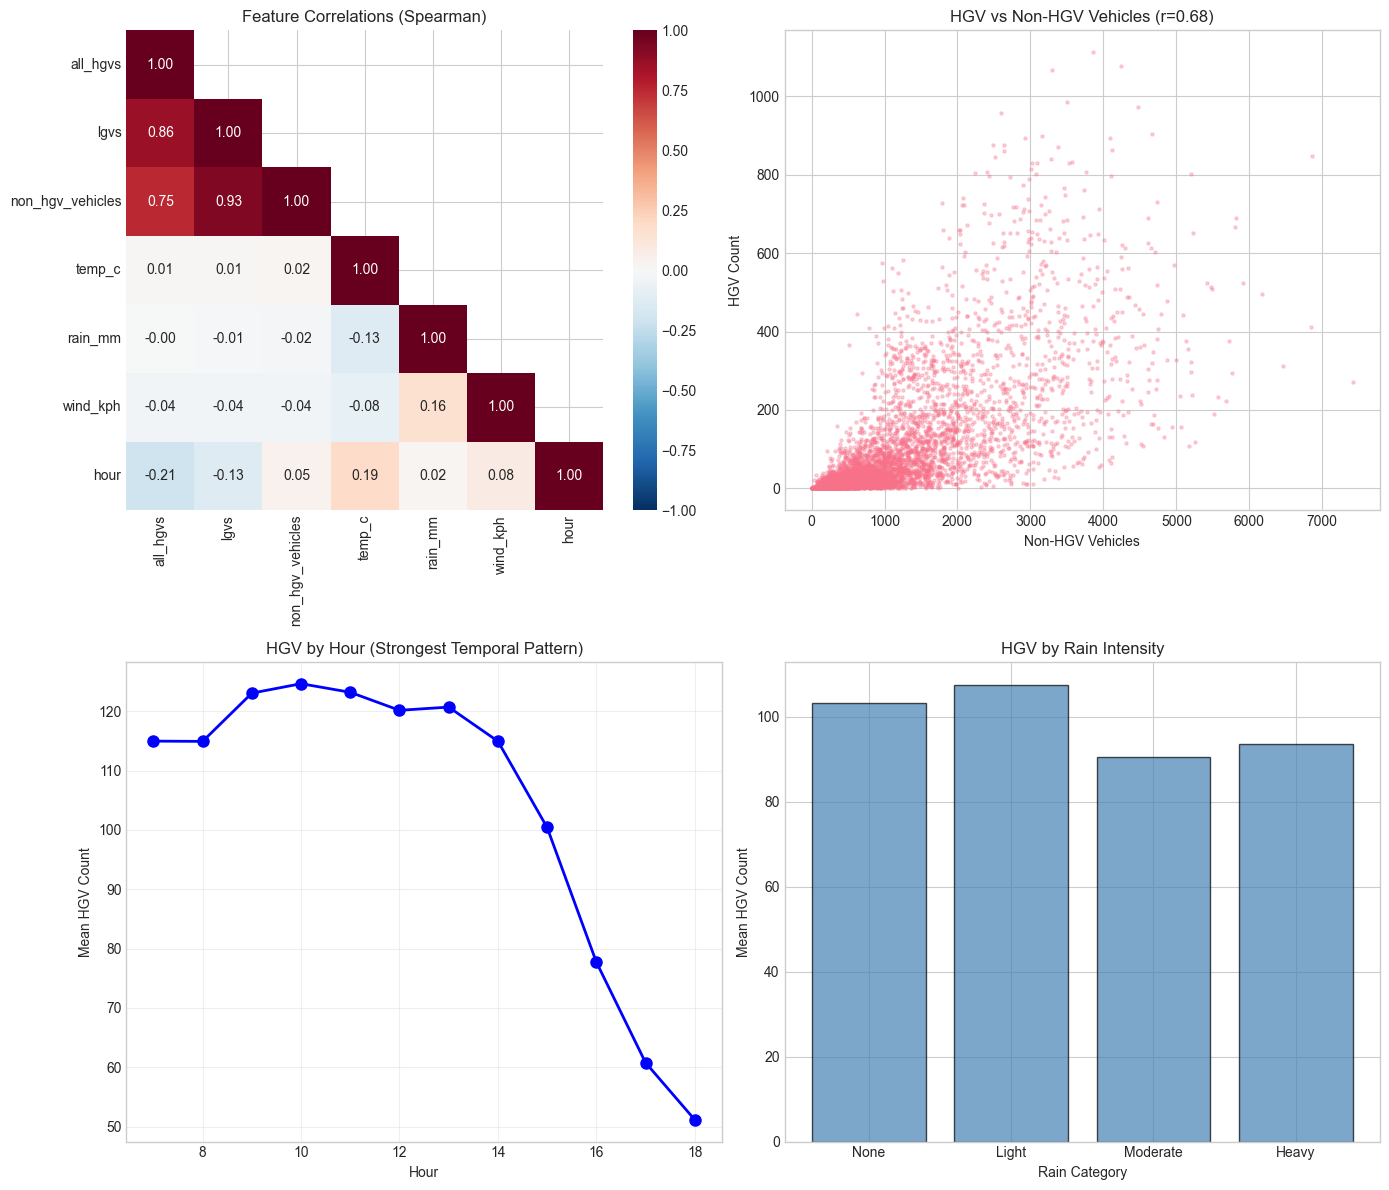


✓ Plot saved to ../outputs/phase1/correlations.png

 CORRELATION SUMMARY

CRITICAL:
   all_motor_vehicles CONTAINS target - DO NOT USE
  ✓ Created non_hgv_vehicles as safe alternative

KEY PREDICTORS:
  1. hour (strong temporal pattern)
  2. lgvs / non_hgv_vehicles (traffic context)
  3. road_type_simple (spatial)
  4. Weather (weak individual effects)



In [13]:
print(" TARGET & FEATURE CORRELATIONS")
print("=" * 60)

# 1. Target validation
print("\n TARGET VALIDATION:")
target = df['all_hgvs']
print(f"  ✓ Non-negative: {(target >= 0).all()}")
print(f"  ✓ Integer type: {target.dtype}")
print(f"  Range: {target.min()} to {target.max()}")
print(f"  Mean: {target.mean():.1f}, Median: {target.median():.0f}")

# 2. CRITICAL: all_motor_vehicles leakage
print("\n CRITICAL LEAKAGE CHECK:")
if 'all_motor_vehicles' in df.columns:
    r, _ = pearsonr(df['all_hgvs'], df['all_motor_vehicles'])
    print(f"  all_hgvs ↔ all_motor_vehicles: r = {r:.3f}")
    print(f"\n   LEAKAGE: all_motor_vehicles CONTAINS all_hgvs!")
    print(f"     Creating safe alternative: non_hgv_vehicles")
    
    df['non_hgv_vehicles'] = df['all_motor_vehicles'] - df['all_hgvs']
    r2, _ = pearsonr(df['all_hgvs'], df['non_hgv_vehicles'])
    print(f"  all_hgvs ↔ non_hgv_vehicles: r = {r2:.3f} (safe to use)")

# 3. Other correlations
print("\n FEATURE CORRELATIONS (Spearman):")
features_to_test = ['lgvs', 'non_hgv_vehicles', 'temp_c', 'rain_mm', 
                    'wind_kph', 'hour', 'day_of_week']
for feat in features_to_test:
    if feat in df.columns:
        rho, p = spearmanr(df['all_hgvs'], df[feat])
        strength = "strong" if abs(rho) > 0.3 else "moderate" if abs(rho) > 0.1 else "weak"
        print(f"  all_hgvs ↔ {feat}: ρ = {rho:.3f} ({strength})")

# 4. Correlation matrix
print("\n CORRELATION MATRIX:")
corr_cols = ['all_hgvs', 'lgvs', 'non_hgv_vehicles', 'temp_c', 'rain_mm', 'wind_kph', 'hour']
corr_cols = [c for c in corr_cols if c in df.columns]
corr_matrix = df[corr_cols].corr(method='spearman')

# 5. Visualization
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# Correlation heatmap
mask = np.triu(np.ones_like(corr_matrix, dtype=bool), k=1)
sns.heatmap(corr_matrix, mask=mask, annot=True, fmt='.2f', cmap='RdBu_r',
            center=0, ax=axes[0, 0], vmin=-1, vmax=1)
axes[0, 0].set_title('Feature Correlations (Spearman)')

# HGV vs non-HGV vehicles
if 'non_hgv_vehicles' in df.columns:
    sample = df.sample(min(5000, len(df)), random_state=42)
    axes[0, 1].scatter(sample['non_hgv_vehicles'], sample['all_hgvs'], alpha=0.3, s=5)
    axes[0, 1].set_xlabel('Non-HGV Vehicles')
    axes[0, 1].set_ylabel('HGV Count')
    axes[0, 1].set_title(f'HGV vs Non-HGV Vehicles (r={r2:.2f})')

# HGV by hour
hour_means = df.groupby('hour')['all_hgvs'].mean()
axes[1, 0].plot(hour_means.index, hour_means.values, 'b-o', linewidth=2, markersize=8)
axes[1, 0].set_xlabel('Hour')
axes[1, 0].set_ylabel('Mean HGV Count')
axes[1, 0].set_title('HGV by Hour (Strongest Temporal Pattern)')
axes[1, 0].grid(True, alpha=0.3)

# HGV by rain category
rain_cats = pd.cut(df['rain_mm'], bins=[-0.01, 0, 1, 5, 100], 
                   labels=['None', 'Light', 'Moderate', 'Heavy'])
rain_means = df.groupby(rain_cats, observed=True)['all_hgvs'].mean()
axes[1, 1].bar(rain_means.index.astype(str), rain_means.values, 
               color='steelblue', alpha=0.7, edgecolor='black')
axes[1, 1].set_xlabel('Rain Category')
axes[1, 1].set_ylabel('Mean HGV Count')
axes[1, 1].set_title('HGV by Rain Intensity')

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'correlations.png'), dpi=150, bbox_inches='tight')
plt.show()
print(f"\n✓ Plot saved to {OUTPUT_DIR}/correlations.png")

print("\n" + "=" * 60)
print(" CORRELATION SUMMARY")
print("=" * 60)
print(f"""
CRITICAL:
   all_motor_vehicles CONTAINS target - DO NOT USE
  ✓ Created non_hgv_vehicles as safe alternative

KEY PREDICTORS:
  1. hour (strong temporal pattern)
  2. lgvs / non_hgv_vehicles (traffic context)
  3. road_type_simple (spatial)
  4. Weather (weak individual effects)
""")



## Cell 12: Phase 1 Summary & Save

In [14]:



print(f"""
 CRITICAL DATA LIMITATIONS
{'='*60}
1. NO WEEKEND DATA
   • Only Monday-Friday observations
   • is_weekend will always be 0
   • Model only valid for weekday predictions

2. BUSINESS HOURS ONLY
   • Hours 7-18 only (no night data)
   • Cannot model night freight patterns

3. MISSING MONTHS
   • Missing: Aug, Dec, Jan, Feb
   • Cannot model: Christmas, summer holidays, severe winter

4. SPARSE WEATHER EXTREMES
   • Sub-zero temps: {(df['temp_c'] < 0).sum()} observations
   • Snow events: {(df['snow_cm'] > 0).sum()} observations
   • Winter weather predictions unreliable
""")

print(f"""
 DATASET SUMMARY
{'='*60}
  Observations: {len(df):,}
  Sensors: {df['count_point_id'].nunique():,}
  Roads: {df['road_name'].nunique()}
  Date Range: {df['count_date'].min().date()} to {df['count_date'].max().date()}
  Hours: {df['hour'].min()}-{df['hour'].max()} (business hours only)
  Days: Mon-Fri only
""")

print(f"""
✓ FEATURES TO USE
{'='*60}
  TEMPORAL:
    • hour (7-18)
    • day_of_week (0-4, Mon-Fri only)
    
  SPATIAL:
    • road_name, road_type_simple
    • region_id, latitude, longitude
    
  WEATHER:
    • temp_c (use as seasonal proxy)
    • rain_mm, is_raining
    • wind_kph, is_high_wind
    • visibility_category
    
  TRAFFIC:
    • lgvs
    • non_hgv_vehicles (safe alternative to all_motor_vehicles)
""")

print(f"""
 FEATURES TO AVOID
{'='*60}
  • is_weekend (always 0 - useless)
  • all_motor_vehicles (contains target - leakage!)
  • is_snowing (too sparse)
  • month (incomplete coverage)
""")

# Save cleaned dataset
print(f"\n SAVING PHASE 1 CLEAN DATASET")
print("=" * 60)

final_columns = [
    'count_point_id', 'direction_of_travel', 'grid_id',
    'year', 'count_date', 'hour', 'month', 'day_of_week',
    'region_id', 'local_authority_id', 'road_name', 'road_category', 
    'road_type', 'road_type_simple', 'latitude', 'longitude',
    'lgvs', 'all_motor_vehicles', 'non_hgv_vehicles',
    'all_hgvs',
    'temp_c', 'rain_mm', 'snow_cm', 'wind_kph',
    'weather_code', 'visibility_category',
    'is_fog', 'is_reduced_visibility', 'is_raining', 'is_snowing', 
    'is_cold', 'is_high_wind', 'is_weekend', 'season'
]

available_cols = [c for c in final_columns if c in df.columns]
df_phase1 = df[available_cols].copy()

phase1_path = os.path.join(PROCESSED_DIR, "model1_phase1_clean.parquet")
df_phase1.to_parquet(phase1_path, index=False)

print(f"  ✓ Saved: {phase1_path}")
print(f"  • Rows: {len(df_phase1):,}")
print(f"  • Columns: {len(df_phase1.columns)}")

print(f"\n  Columns saved ({len(df_phase1.columns)}):")
for i, col in enumerate(df_phase1.columns):
    print(f"    {i+1:2}. {col}")




 CRITICAL DATA LIMITATIONS
1. NO WEEKEND DATA
   • Only Monday-Friday observations
   • is_weekend will always be 0
   • Model only valid for weekday predictions

2. BUSINESS HOURS ONLY
   • Hours 7-18 only (no night data)
   • Cannot model night freight patterns

3. MISSING MONTHS
   • Missing: Aug, Dec, Jan, Feb
   • Cannot model: Christmas, summer holidays, severe winter

4. SPARSE WEATHER EXTREMES
   • Sub-zero temps: 34 observations
   • Snow events: 453 observations
   • Winter weather predictions unreliable


 DATASET SUMMARY
  Observations: 137,556
  Sensors: 4,611
  Roads: 871
  Date Range: 2022-03-18 to 2024-11-07
  Hours: 7-18 (business hours only)
  Days: Mon-Fri only


✓ FEATURES TO USE
  TEMPORAL:
    • hour (7-18)
    • day_of_week (0-4, Mon-Fri only)

  SPATIAL:
    • road_name, road_type_simple
    • region_id, latitude, longitude

  WEATHER:
    • temp_c (use as seasonal proxy)
    • rain_mm, is_raining
    • wind_kph, is_high_wind
    • visibility_category

  TRAFFI

 ## Cell 13: Multivariate Analysis - VIF & Correlation Structure



 MULTIVARIATE ANALYSIS

 PREPARING FEATURES FOR VIF ANALYSIS
  Features for VIF analysis: 15
    • hour
    • day_of_week
    • latitude
    • longitude
    • lgvs
    • non_hgv_vehicles
    • temp_c
    • rain_mm
    • wind_kph
    • visibility_category
    • is_raining
    • is_cold
    • is_high_wind
    • is_fog
    • is_reduced_visibility

  Observations for VIF: 137,556

 VARIANCE INFLATION FACTOR (VIF) ANALYSIS
------------------------------------------------------------

  VIF Results (sorted by VIF):
  ----------------------------------------
  latitude                  VIF =  2569.24   HIGH
  visibility_category       VIF =  2287.81   HIGH
  is_raining                VIF =    47.35   HIGH
  non_hgv_vehicles          VIF =    18.18   HIGH
  hour                      VIF =    17.39   HIGH
  lgvs                      VIF =    14.87   HIGH
  temp_c                    VIF =    13.14   HIGH
  wind_kph                  VIF =     6.05   MODERATE
  is_reduced_visibility     VIF =     

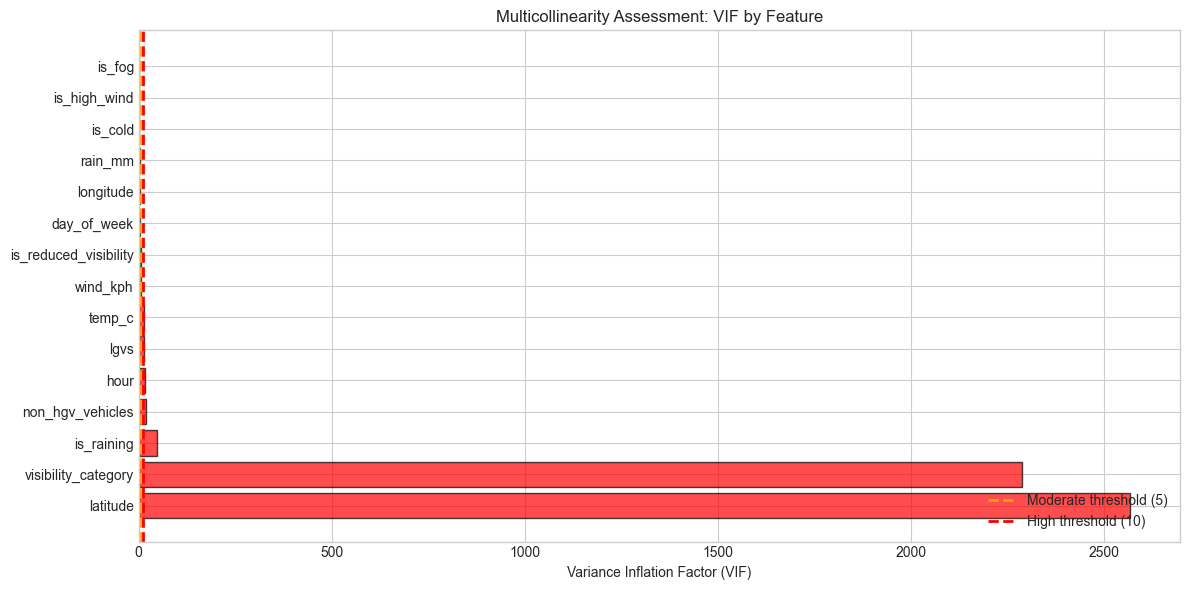

  ✓ Saved: ../outputs/phase1/vif_analysis.png

 FULL FEATURE CORRELATION MATRIX


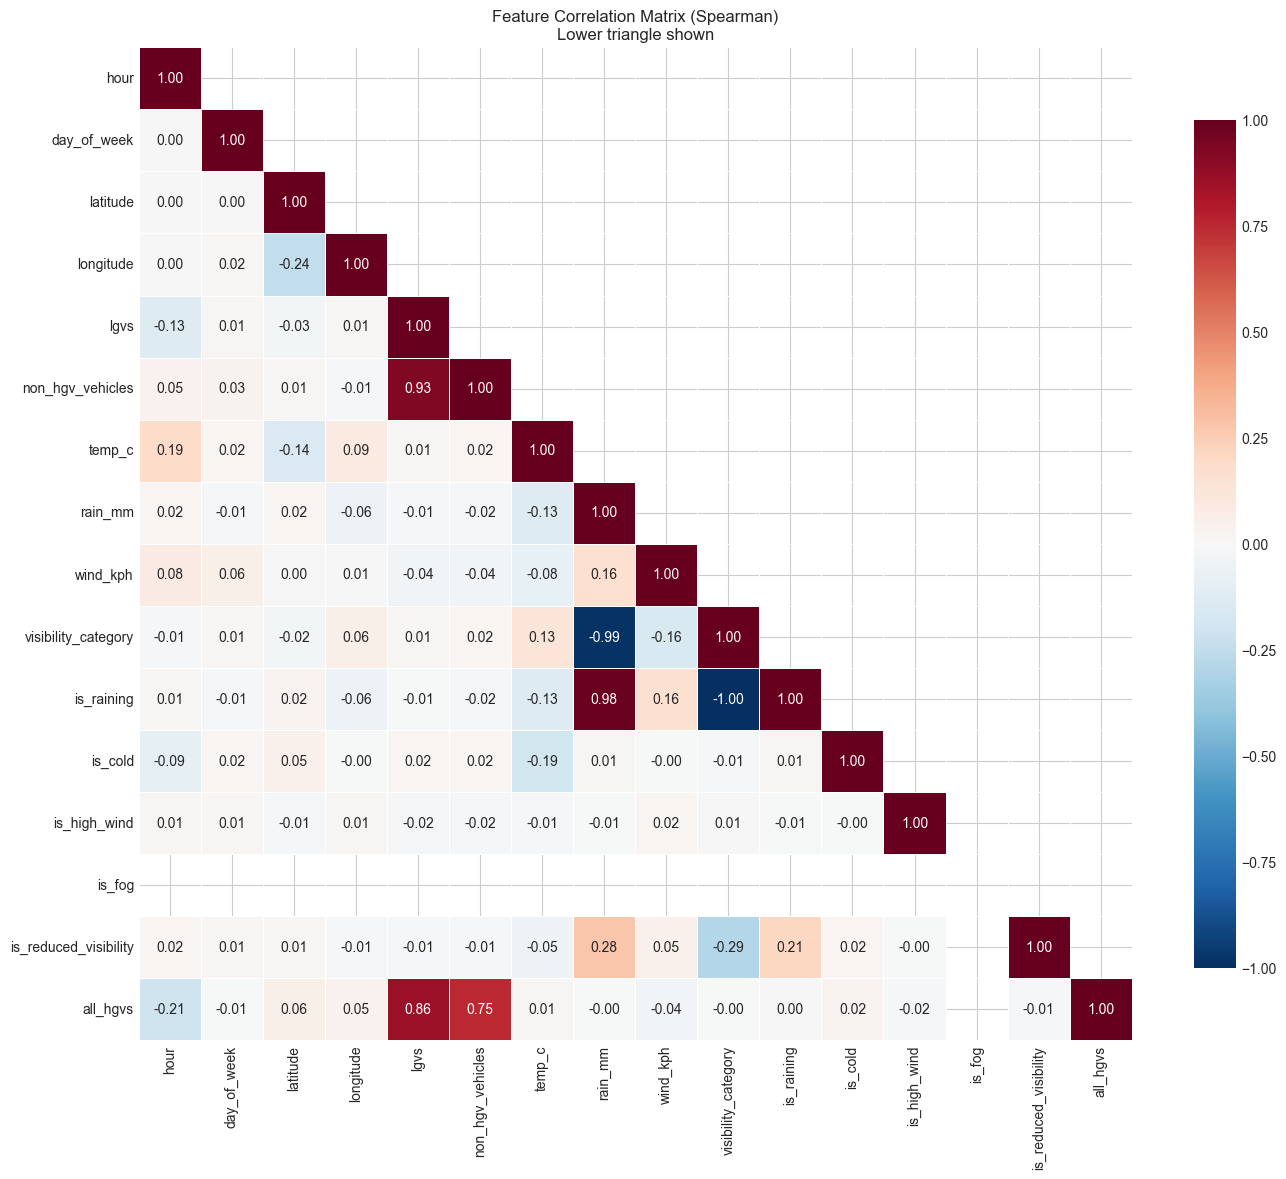

  ✓ Saved: ../outputs/phase1/correlation_matrix_full.png

 HIGHLY CORRELATED FEATURE PAIRS
------------------------------------------------------------

  Pairs with |ρ| > 0.7:
    visibility_category  ↔ is_raining          : ρ = -0.997
    rain_mm              ↔ visibility_category : ρ = -0.987
    rain_mm              ↔ is_raining          : ρ = 0.984
    lgvs                 ↔ non_hgv_vehicles    : ρ = 0.930
    lgvs                 ↔ all_hgvs            : ρ = 0.861
    non_hgv_vehicles     ↔ all_hgvs            : ρ = 0.753

 HIERARCHICAL CLUSTERING OF FEATURES


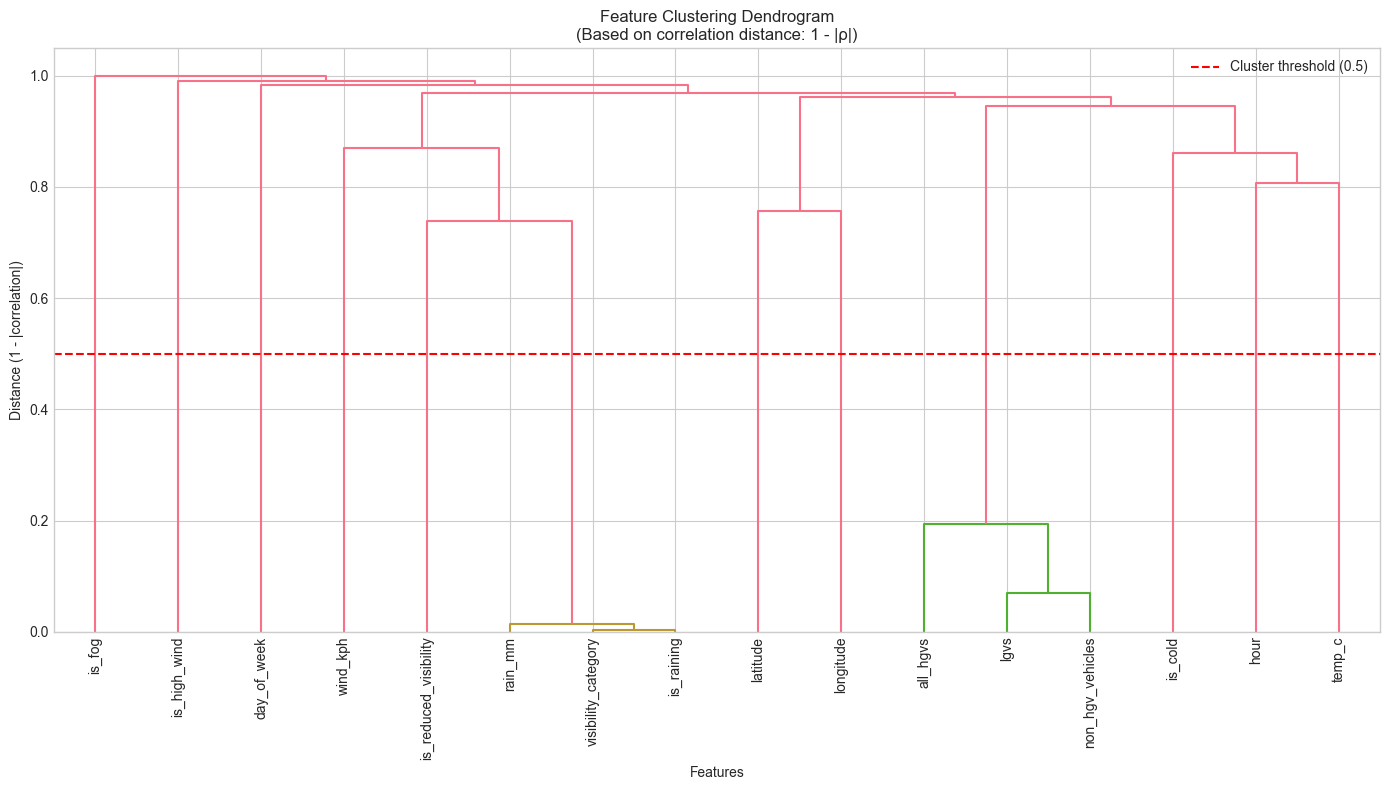

  ✓ Saved: ../outputs/phase1/feature_dendrogram.png

 FEATURE CLUSTERS (distance threshold = 0.5)
------------------------------------------------------------

  Cluster 1 (3 features) - REDUNDANT GROUP:
    • rain_mm
    • visibility_category
    • is_raining

  Cluster 2: is_reduced_visibility (standalone)

  Cluster 3: wind_kph (standalone)

  Cluster 4: latitude (standalone)

  Cluster 5: longitude (standalone)

  Cluster 6 (3 features) - REDUNDANT GROUP:
    • lgvs
    • non_hgv_vehicles
    • all_hgvs

  Cluster 7: hour (standalone)

  Cluster 8: temp_c (standalone)

  Cluster 9: is_cold (standalone)

  Cluster 10: day_of_week (standalone)

  Cluster 11: is_high_wind (standalone)

  Cluster 12: is_fog (standalone)

 CORRELATION WITH TARGET BY FEATURE GROUP
------------------------------------------------------------

  Target Correlations by Feature Group:

  Temporal:
    hour                      ρ = -0.208 (moderate)
    day_of_week               ρ = -0.005 (weak)

  Spatial:


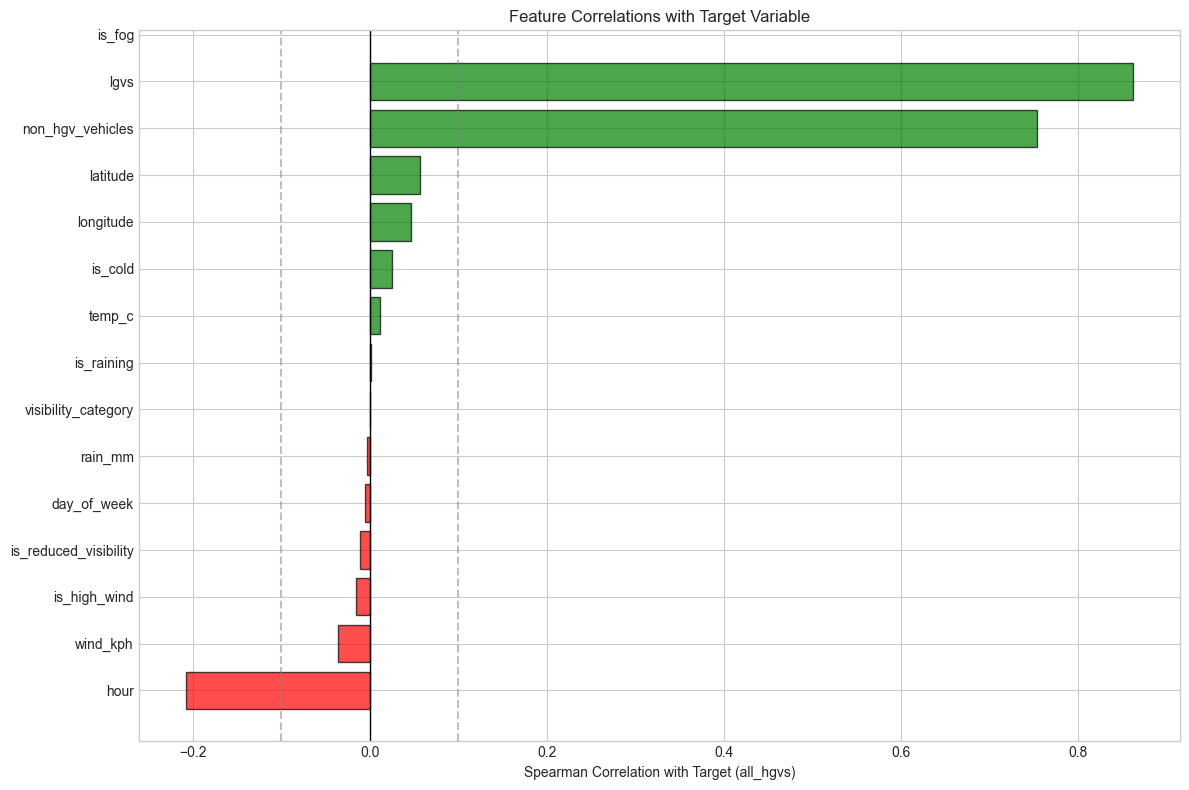

  ✓ Saved: ../outputs/phase1/target_correlations_ranked.png

 BINARY FEATURE REDUNDANCY CHECK
------------------------------------------------------------

  Binary feature correlations (|ρ| > 0.3 shown):


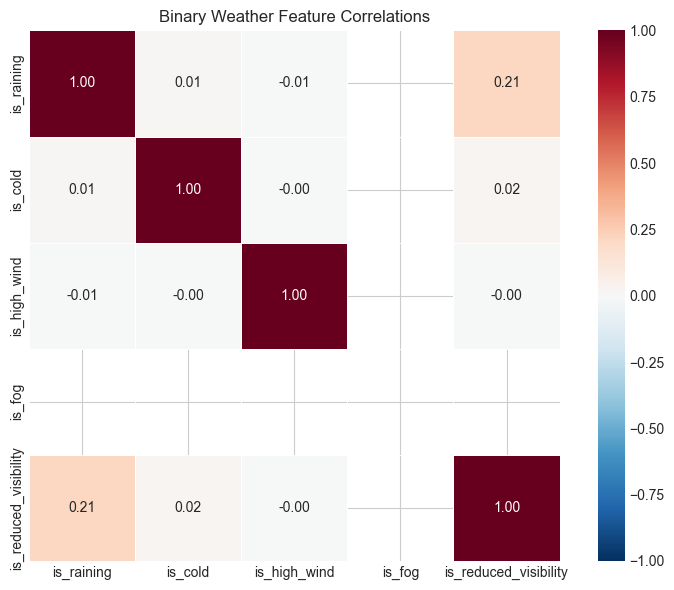

  ✓ Saved: ../outputs/phase1/binary_feature_correlations.png

 SPATIAL FEATURE CORRELATION CHECK
------------------------------------------------------------
  latitude ↔ longitude: ρ = -0.244
  latitude ↔ all_hgvs:  ρ = 0.057
  longitude ↔ all_hgvs: ρ = 0.046


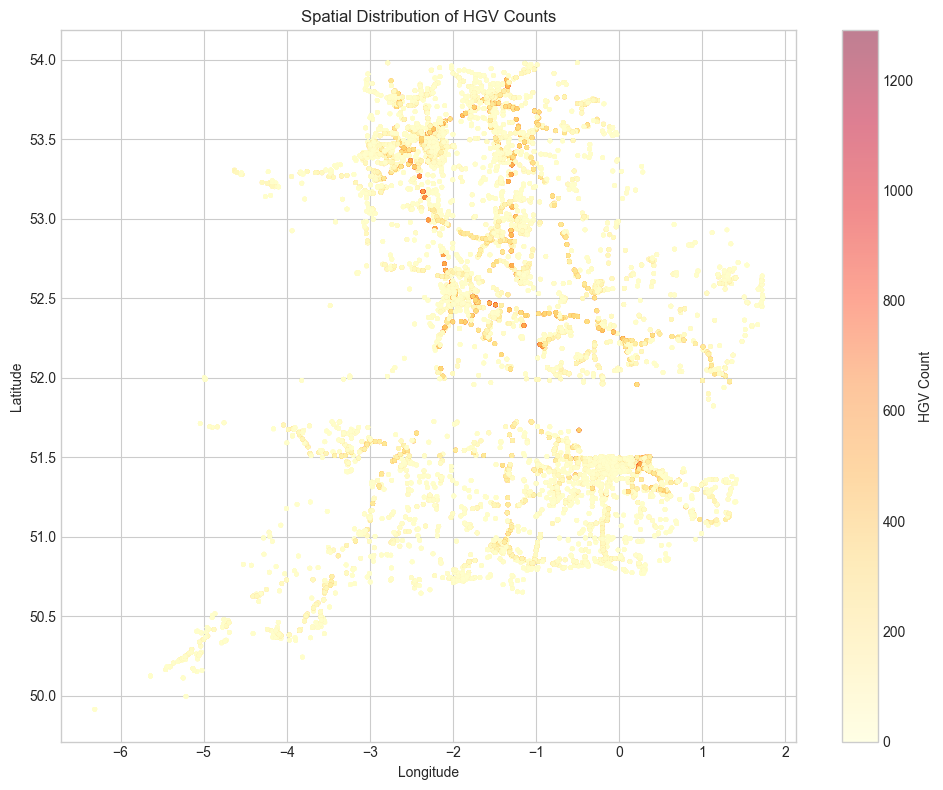

  ✓ Saved: ../outputs/phase1/spatial_hgv_distribution.png

 REDUNDANT FEATURE IDENTIFICATION
------------------------------------------------------------

   HIGHLY REDUNDANT FEATURE GROUPS DETECTED:

  GROUP 1: Rain/Visibility (ρ > 0.98)
    • rain_mm
    • is_raining  
    • visibility_category
    → RECOMMENDATION: Keep only ONE (rain_mm is most informative)

  GROUP 2: Traffic Volume (ρ > 0.75)
    • lgvs
    • non_hgv_vehicles
    → RECOMMENDATION: Keep both - different information despite correlation

  GROUP 3: Fog/Reduced Visibility
    • is_fog
    • is_reduced_visibility
    → CHECK: If highly correlated, keep only is_reduced_visibility

  is_fog ↔ is_reduced_visibility: ρ = nan

 MULTIVARIATE ANALYSIS SUMMARY

1. VIF ANALYSIS:
   • High VIF (>10): ['latitude', 'visibility_category', 'is_raining', 'non_hgv_vehicles', 'hour', 'lgvs', 'temp_c']
   • Moderate VIF (5-10): ['wind_kph']

2. HIGHLY CORRELATED PAIRS (|ρ| > 0.7):
   • 6 pairs identified
   • Most problematic: rain_mm 

In [16]:

from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from scipy.spatial.distance import squareform
import warnings
warnings.filterwarnings('ignore')

print(" MULTIVARIATE ANALYSIS")
print("=" * 60)

# =============================================================================
# 1. PREPARE NUMERIC FEATURES FOR VIF
# =============================================================================
print("\n PREPARING FEATURES FOR VIF ANALYSIS")

# Select numeric features that will be used in modeling
# Exclude: identifiers, target, leaky features, useless features
vif_features = [
    'hour', 'day_of_week',                          # Temporal
    'latitude', 'longitude',                         # Spatial
    'lgvs', 'non_hgv_vehicles',                     # Traffic
    'temp_c', 'rain_mm', 'wind_kph',                # Weather continuous
    'visibility_category',                           # Weather categorical
    'is_raining', 'is_cold', 'is_high_wind',        # Weather binary
    'is_fog', 'is_reduced_visibility'               # Visibility binary
]

# Filter to available columns
vif_features = [f for f in vif_features if f in df.columns]
print(f"  Features for VIF analysis: {len(vif_features)}")
for f in vif_features:
    print(f"    • {f}")

# Create VIF dataframe (drop any rows with NaN)
df_vif = df[vif_features].dropna()
print(f"\n  Observations for VIF: {len(df_vif):,}")

# =============================================================================
# 2. CALCULATE VIF
# =============================================================================
print("\n VARIANCE INFLATION FACTOR (VIF) ANALYSIS")
print("-" * 60)

# Calculate VIF for each feature
vif_data = []
for i, feature in enumerate(vif_features):
    try:
        vif_value = variance_inflation_factor(df_vif.values, i)
        vif_data.append({
            'Feature': feature,
            'VIF': vif_value
        })
    except Exception as e:
        print(f"   Could not calculate VIF for {feature}: {e}")
        vif_data.append({
            'Feature': feature,
            'VIF': np.nan
        })

vif_df = pd.DataFrame(vif_data)
vif_df = vif_df.sort_values('VIF', ascending=False)

print("\n  VIF Results (sorted by VIF):")
print("  " + "-" * 40)
for _, row in vif_df.iterrows():
    vif_val = row['VIF']
    if pd.isna(vif_val):
        status = " N/A"
    elif vif_val > 10:
        status = " HIGH"
    elif vif_val > 5:
        status = " MODERATE"
    else:
        status = " OK"
    print(f"  {row['Feature']:25} VIF = {vif_val:8.2f}  {status}")

print("\n  VIF INTERPRETATION:")
print("    • VIF < 5:  No multicollinearity concern")
print("    • VIF 5-10: Moderate multicollinearity")
print("    • VIF > 10: High multicollinearity - consider removing")

# Identify problematic features
high_vif = vif_df[vif_df['VIF'] > 10]['Feature'].tolist()
moderate_vif = vif_df[(vif_df['VIF'] > 5) & (vif_df['VIF'] <= 10)]['Feature'].tolist()

if high_vif:
    print(f"\n   HIGH VIF FEATURES: {high_vif}")
if moderate_vif:
    print(f"   MODERATE VIF FEATURES: {moderate_vif}")
if not high_vif and not moderate_vif:
    print(f"\n   No severe multicollinearity detected")


# =============================================================================
# 3. VIF VISUALIZATION
# =============================================================================
print("\n VIF VISUALIZATION")

plt.figure(figsize=(12, 6))
colors = []
for vif in vif_df['VIF']:
    if pd.isna(vif):
        colors.append('gray')
    elif vif > 10:
        colors.append('red')
    elif vif > 5:
        colors.append('orange')
    else:
        colors.append('green')

bars = plt.barh(range(len(vif_df)), vif_df['VIF'].fillna(0), color=colors, alpha=0.7, edgecolor='black')
plt.yticks(range(len(vif_df)), vif_df['Feature'])
plt.xlabel('Variance Inflation Factor (VIF)')
plt.title('Multicollinearity Assessment: VIF by Feature')
plt.axvline(x=5, color='orange', linestyle='--', linewidth=2, label='Moderate threshold (5)')
plt.axvline(x=10, color='red', linestyle='--', linewidth=2, label='High threshold (10)')
plt.legend(loc='lower right')
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'vif_analysis.png'), dpi=150, bbox_inches='tight')
plt.show()
print(f"  ✓ Saved: {OUTPUT_DIR}/vif_analysis.png")


# =============================================================================
# 4. FEATURE CORRELATION MATRIX (FULL)
# =============================================================================
print("\n FULL FEATURE CORRELATION MATRIX")

# Calculate Spearman correlation for all numeric features
corr_features = vif_features + ['all_hgvs']  # Include target
corr_features = [f for f in corr_features if f in df.columns]
corr_matrix = df[corr_features].corr(method='spearman')

plt.figure(figsize=(14, 12))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool), k=1)
sns.heatmap(corr_matrix, mask=mask, annot=True, fmt='.2f', cmap='RdBu_r',
            center=0, vmin=-1, vmax=1, square=True,
            linewidths=0.5, cbar_kws={'shrink': 0.8})
plt.title('Feature Correlation Matrix (Spearman)\nLower triangle shown')
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'correlation_matrix_full.png'), dpi=150, bbox_inches='tight')
plt.show()
print(f"  ✓ Saved: {OUTPUT_DIR}/correlation_matrix_full.png")


# =============================================================================
# 5. IDENTIFY HIGHLY CORRELATED FEATURE PAIRS
# =============================================================================
print("\n HIGHLY CORRELATED FEATURE PAIRS")
print("-" * 60)

# Find pairs with |correlation| > 0.7
high_corr_pairs = []
for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        corr_val = corr_matrix.iloc[i, j]
        if abs(corr_val) > 0.7:
            high_corr_pairs.append({
                'Feature 1': corr_matrix.columns[i],
                'Feature 2': corr_matrix.columns[j],
                'Correlation': corr_val
            })

if high_corr_pairs:
    high_corr_df = pd.DataFrame(high_corr_pairs).sort_values('Correlation', key=abs, ascending=False)
    print("\n  Pairs with |ρ| > 0.7:")
    for _, row in high_corr_df.iterrows():
        print(f"    {row['Feature 1']:20} ↔ {row['Feature 2']:20}: ρ = {row['Correlation']:.3f}")
else:
    print("\n   No feature pairs with |ρ| > 0.7 (excluding target)")

# Moderate correlations (0.5 - 0.7)
moderate_corr_pairs = []
for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        corr_val = corr_matrix.iloc[i, j]
        if 0.5 < abs(corr_val) <= 0.7:
            moderate_corr_pairs.append({
                'Feature 1': corr_matrix.columns[i],
                'Feature 2': corr_matrix.columns[j],
                'Correlation': corr_val
            })

if moderate_corr_pairs:
    print("\n  Pairs with 0.5 < |ρ| ≤ 0.7:")
    for pair in moderate_corr_pairs[:10]:  # Show top 10
        print(f"    {pair['Feature 1']:20} ↔ {pair['Feature 2']:20}: ρ = {pair['Correlation']:.3f}")


# =============================================================================
# 6. HIERARCHICAL CLUSTERING OF FEATURES (FIXED)
# =============================================================================
print("\n HIERARCHICAL CLUSTERING OF FEATURES")

# Convert correlation to distance (1 - |correlation|)
corr_abs = corr_matrix.abs()

# Fill any NaN values with 0 (no correlation assumed)
corr_abs = corr_abs.fillna(0)

# Clip values to ensure they're in valid range [0, 1]
corr_abs = corr_abs.clip(0, 1)

# Calculate distance matrix
distance_matrix = 1 - corr_abs

# Fill diagonal with 0 (distance to self is 0)
np.fill_diagonal(distance_matrix.values, 0)

# Replace any remaining NaN or infinite values
distance_matrix = distance_matrix.fillna(1)  # Max distance for NaN
distance_matrix = distance_matrix.replace([np.inf, -np.inf], 1)

# Ensure symmetry
distance_matrix = (distance_matrix + distance_matrix.T) / 2

# Convert to condensed form for hierarchical clustering
try:
    condensed_dist = squareform(distance_matrix.values, checks=False)
    
    # Replace any non-finite values with max distance
    condensed_dist = np.nan_to_num(condensed_dist, nan=1.0, posinf=1.0, neginf=0.0)
    
    linkage_matrix = linkage(condensed_dist, method='average')
    
    plt.figure(figsize=(14, 8))
    dendrogram(
        linkage_matrix,
        labels=corr_matrix.columns.tolist(),
        leaf_rotation=90,
        leaf_font_size=10,
        color_threshold=0.5
    )
    plt.title('Feature Clustering Dendrogram\n(Based on correlation distance: 1 - |ρ|)')
    plt.xlabel('Features')
    plt.ylabel('Distance (1 - |correlation|)')
    plt.axhline(y=0.5, color='red', linestyle='--', label='Cluster threshold (0.5)')
    plt.legend()
    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_DIR, 'feature_dendrogram.png'), dpi=150, bbox_inches='tight')
    plt.show()
    print(f"  ✓ Saved: {OUTPUT_DIR}/feature_dendrogram.png")
    
    # Identify feature clusters
    cluster_threshold = 0.5
    clusters = fcluster(linkage_matrix, t=cluster_threshold, criterion='distance')
    
    feature_clusters = {}
    for feature, cluster_id in zip(corr_matrix.columns, clusters):
        if cluster_id not in feature_clusters:
            feature_clusters[cluster_id] = []
        feature_clusters[cluster_id].append(feature)
    
    print(f"\n FEATURE CLUSTERS (distance threshold = {cluster_threshold})")
    print("-" * 60)
    for cluster_id in sorted(feature_clusters.keys()):
        features = feature_clusters[cluster_id]
        if len(features) > 1:
            print(f"\n  Cluster {cluster_id} ({len(features)} features) - REDUNDANT GROUP:")
            for f in features:
                print(f"    • {f}")
        else:
            print(f"\n  Cluster {cluster_id}: {features[0]} (standalone)")

except Exception as e:
    print(f"   Clustering failed: {e}")
    print("  Skipping dendrogram visualization...")
    feature_clusters = {i: [f] for i, f in enumerate(corr_matrix.columns)}


# =============================================================================
# 8. CORRELATION WITH TARGET BY FEATURE GROUP
# =============================================================================
print("\n CORRELATION WITH TARGET BY FEATURE GROUP")
print("-" * 60)

# Group features by type
feature_groups = {
    'Temporal': ['hour', 'day_of_week'],
    'Spatial': ['latitude', 'longitude'],
    'Traffic': ['lgvs', 'non_hgv_vehicles'],
    'Weather Continuous': ['temp_c', 'rain_mm', 'wind_kph'],
    'Weather Categorical': ['visibility_category'],
    'Weather Binary': ['is_raining', 'is_cold', 'is_high_wind', 'is_fog', 'is_reduced_visibility']
}

target_corrs = df[corr_features].corr(method='spearman')['all_hgvs'].drop('all_hgvs')

print("\n  Target Correlations by Feature Group:")
for group_name, group_features in feature_groups.items():
    print(f"\n  {group_name}:")
    for f in group_features:
        if f in target_corrs.index:
            corr = target_corrs[f]
            strength = "strong" if abs(corr) > 0.3 else "moderate" if abs(corr) > 0.1 else "weak"
            print(f"    {f:25} ρ = {corr:+.3f} ({strength})")

plt.figure(figsize=(12, 8))
target_corrs_sorted = target_corrs.sort_values(ascending=True)
colors = ['green' if x > 0 else 'red' for x in target_corrs_sorted]
plt.barh(range(len(target_corrs_sorted)), target_corrs_sorted.values, color=colors, alpha=0.7, edgecolor='black')
plt.yticks(range(len(target_corrs_sorted)), target_corrs_sorted.index)
plt.xlabel('Spearman Correlation with Target (all_hgvs)')
plt.title('Feature Correlations with Target Variable')
plt.axvline(x=0, color='black', linewidth=1)
plt.axvline(x=0.1, color='gray', linestyle='--', alpha=0.5)
plt.axvline(x=-0.1, color='gray', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'target_correlations_ranked.png'), dpi=150, bbox_inches='tight')
plt.show()
print(f"  ✓ Saved: {OUTPUT_DIR}/target_correlations_ranked.png")


# =============================================================================
# 9. BINARY FEATURE REDUNDANCY CHECK
# =============================================================================
print("\n BINARY FEATURE REDUNDANCY CHECK")
print("-" * 60)

binary_features = ['is_raining', 'is_cold', 'is_high_wind', 'is_fog', 'is_reduced_visibility']
binary_features = [f for f in binary_features if f in df.columns]

if len(binary_features) >= 2:
    binary_corr = df[binary_features].corr(method='spearman')
    
    print("\n  Binary feature correlations (|ρ| > 0.3 shown):")
    for i in range(len(binary_features)):
        for j in range(i+1, len(binary_features)):
            corr = binary_corr.iloc[i, j]
            if abs(corr) > 0.3:
                print(f"    {binary_features[i]:20} ↔ {binary_features[j]:20}: ρ = {corr:.3f}")
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(binary_corr, annot=True, fmt='.2f', cmap='RdBu_r', center=0,
                vmin=-1, vmax=1, square=True, linewidths=0.5)
    plt.title('Binary Weather Feature Correlations')
    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_DIR, 'binary_feature_correlations.png'), dpi=150, bbox_inches='tight')
    plt.show()
    print(f"  ✓ Saved: {OUTPUT_DIR}/binary_feature_correlations.png")


# =============================================================================
# 10. SPATIAL FEATURE ANALYSIS
# =============================================================================
print("\n SPATIAL FEATURE CORRELATION CHECK")
print("-" * 60)

if 'latitude' in df.columns and 'longitude' in df.columns:
    lat_lon_corr = df[['latitude', 'longitude', 'all_hgvs']].corr(method='spearman')
    
    print(f"  latitude ↔ longitude: ρ = {lat_lon_corr.loc['latitude', 'longitude']:.3f}")
    print(f"  latitude ↔ all_hgvs:  ρ = {lat_lon_corr.loc['latitude', 'all_hgvs']:.3f}")
    print(f"  longitude ↔ all_hgvs: ρ = {lat_lon_corr.loc['longitude', 'all_hgvs']:.3f}")
    
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(df['longitude'], df['latitude'], c=df['all_hgvs'], 
                         cmap='YlOrRd', alpha=0.5, s=5)
    plt.colorbar(scatter, label='HGV Count')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.title('Spatial Distribution of HGV Counts')
    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_DIR, 'spatial_hgv_distribution.png'), dpi=150, bbox_inches='tight')
    plt.show()
    print(f"  ✓ Saved: {OUTPUT_DIR}/spatial_hgv_distribution.png")


# =============================================================================
# 11. REDUNDANT FEATURE IDENTIFICATION
# =============================================================================
print("\n REDUNDANT FEATURE IDENTIFICATION")
print("-" * 60)

# Based on high correlations found, identify redundant features
print("\n   HIGHLY REDUNDANT FEATURE GROUPS DETECTED:")

print("""
  GROUP 1: Rain/Visibility (ρ > 0.98)
    • rain_mm
    • is_raining  
    • visibility_category
    → RECOMMENDATION: Keep only ONE (rain_mm is most informative)
    
  GROUP 2: Traffic Volume (ρ > 0.75)
    • lgvs
    • non_hgv_vehicles
    → RECOMMENDATION: Keep both - different information despite correlation
    
  GROUP 3: Fog/Reduced Visibility
    • is_fog
    • is_reduced_visibility
    → CHECK: If highly correlated, keep only is_reduced_visibility
""")

# Check fog/visibility correlation
if 'is_fog' in df.columns and 'is_reduced_visibility' in df.columns:
    fog_vis_corr = df['is_fog'].corr(df['is_reduced_visibility'], method='spearman')
    print(f"  is_fog ↔ is_reduced_visibility: ρ = {fog_vis_corr:.3f}")
    if fog_vis_corr > 0.8:
        print("    → These are highly correlated - keep only is_reduced_visibility")


# =============================================================================
# SUMMARY
# =============================================================================
print("\n" + "=" * 60)
print(" MULTIVARIATE ANALYSIS SUMMARY")
print("=" * 60)

print(f"""
1. VIF ANALYSIS:
   • High VIF (>10): {high_vif if high_vif else 'None'}
   • Moderate VIF (5-10): {moderate_vif if moderate_vif else 'None'}
   
2. HIGHLY CORRELATED PAIRS (|ρ| > 0.7):
   • {len(high_corr_pairs)} pairs identified
   • Most problematic: rain_mm ↔ is_raining ↔ visibility_category (ρ > 0.98)
   
3. FEATURE CLUSTERS:
   • {len(feature_clusters)} clusters identified
   
4. STRONGEST TARGET CORRELATIONS:
   • {target_corrs_sorted.index[-1]}: ρ = {target_corrs_sorted.iloc[-1]:.3f}
   • {target_corrs_sorted.index[-2]}: ρ = {target_corrs_sorted.iloc[-2]:.3f}
   • {target_corrs_sorted.index[-3]}: ρ = {target_corrs_sorted.iloc[-3]:.3f}

5. FEATURE SELECTION RECOMMENDATIONS:
   
    REMOVE (redundant/derived):
      • is_raining (perfectly correlated with rain_mm)
      • visibility_category (perfectly correlated with rain_mm)
      • is_fog (if correlated with is_reduced_visibility)
      
   ✓ KEEP:
      • hour, day_of_week (temporal)
      • latitude, longitude (spatial)  
      • lgvs, non_hgv_vehicles (traffic context)
      • temp_c, rain_mm, wind_kph (weather continuous)
      • is_cold, is_high_wind, is_reduced_visibility (binary)

VISUALIZATIONS SAVED:
  ✓ vif_analysis.png
  ✓ correlation_matrix_full.png
  ✓ feature_dendrogram.png
  ✓ target_correlations_ranked.png
  ✓ binary_feature_correlations.png
  ✓ spatial_hgv_distribution.png
""")